In [15]:
# Jordan Hendriksen - Data Science for Engineers - Further investigations

#importing needed libraries 
import numpy as np #includes all mathematical tools - includes SVD
import matplotlib.pyplot as plt #allows plotting of nice charts
import matplotlib.colors as color # allows for creating colormaps
import pandas as pd #library for importing and managing datasets
import copy
import scipy.stats as stat # for statistical tests like MWW
import math 
from sklearn import preprocessing as pre

#changes property of matplotlib so will visualize in output
%matplotlib inline

# creating a green to red colormap as is preferred
colors = ["green", "black", "red"]
cmap1 = color.LinearSegmentedColormap.from_list("mycmap", colors)

In [2]:
# Load in compiled cervical cancer data - both scaled and raw gene expression data was given by TCGA - these are just gene
# expression values w/o labels

# scaled data in its original order 
scaledData = pd.read_csv("/Users\Jordan\Documents\GitHub\PythonCode\Data Science for Engineers\BME6900 Cont\scaledData1noSort.csv")
# scaled data sorted by classification of cervical cancer
scaledDataType = pd.read_csv("/Users\Jordan\Documents\GitHub\PythonCode\Data Science for Engineers\BME6900 Cont\scaledData1typeSort.csv")
# scaled data sorted by age at diagnosis
scaledDataAge = pd.read_csv("/Users\Jordan\Documents\GitHub\PythonCode\Data Science for Engineers\BME6900 Cont\scaledDataAgeSort.csv")
# load in geneNames
geneNames = geneName = pd.read_csv("C:/Users\Jordan\Documents\GitHub\PythonCode\Data Science for Engineers\BME6900 Cont\geneNamesDefault.csv")

In [3]:
# zero mean center the data across its rows and columns as a preprocessing step to make it symmetric - I will perform 
# the same statistical analysis for the same rows and columns as was done above to see how the preprocessing affects the results

# the sklearn.preprocessing.scale() function performs both zero-mean centering adn unit variance scaling for the entire array
# so this will be used for efficiencies sake - I think that the unit variance scaling may have a fairly large impact on the 
# values computed by the SVD

from sklearn import preprocessing as pre

scaledDataTypeZeroUnit = pre.scale(scaledDataType)

# confirm that means are now zero and the variance is 1

meanScaled = scaledDataTypeZeroUnit.mean(axis = 0)
maxMS = max(meanScaled)
minMS = min(meanScaled)
print("The maximum mean of the preprocessed data is:",maxMS,"the minimum is",minMS)

varScaled = scaledDataTypeZeroUnit.std(axis = 0)
maxVar = max(varScaled)
minVar = min(varScaled)
print("The max and min variance of the preprocessed data are: ",maxVar,",",minVar)


The maximum mean of the preprocessed data is: 3.4609972516322465e-17 the minimum is -4.014756811893406e-17
The max and min variance of the preprocessed data are:  1.0000000000000002 , 0.9999999999999997


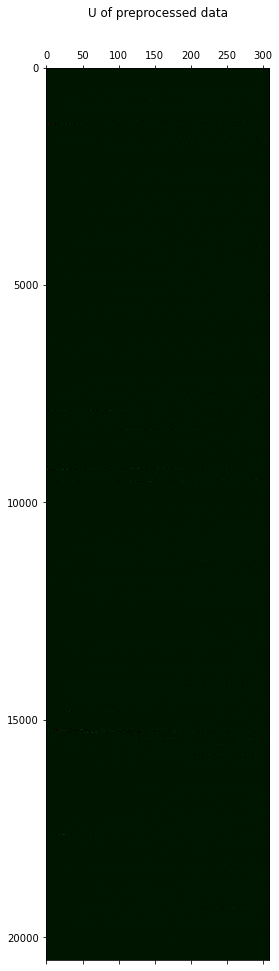

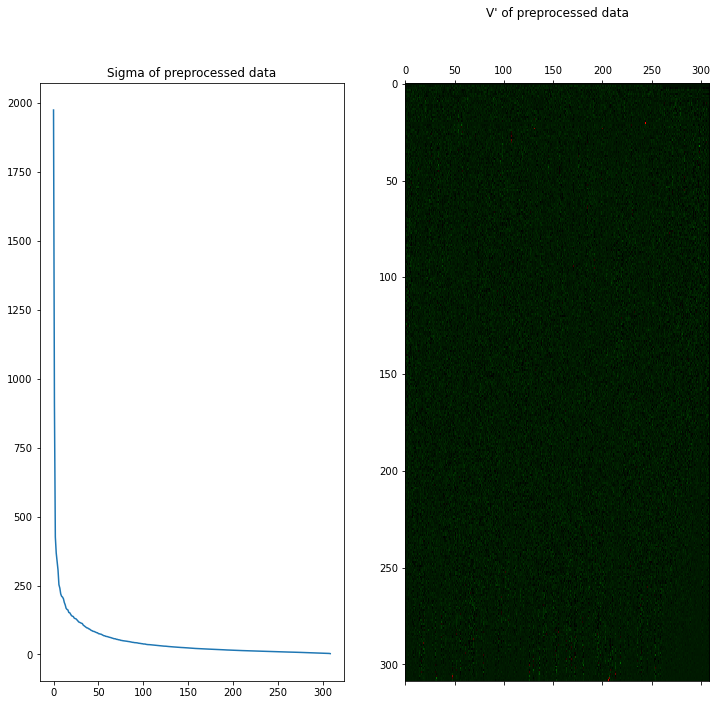

In [4]:
#compute the SVD, visualize and MWW pvalue/boxplots

UsTypeZU, SsTypeZU, VTsTypeZU = np.linalg.svd(scaledDataTypeZeroUnit,full_matrices = False)

# visualize the output of the SVD
plt.matshow(UsTypeZU,cmap = cmap1, aspect = 'auto')
plt.title("U of preprocessed data")
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(SsTypeZU)
ax1.title.set_text("Sigma of preprocessed data")
ax2.matshow(VTsTypeZU,cmap = cmap1, aspect = 'auto')
ax2.set_title("V' of preprocessed data",y=1.1)
fig.set_size_inches(12,11)


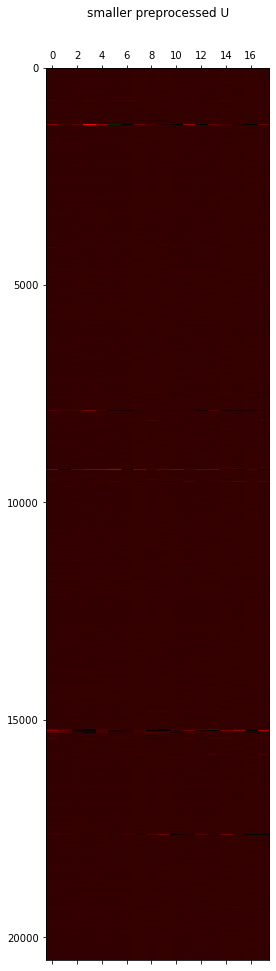

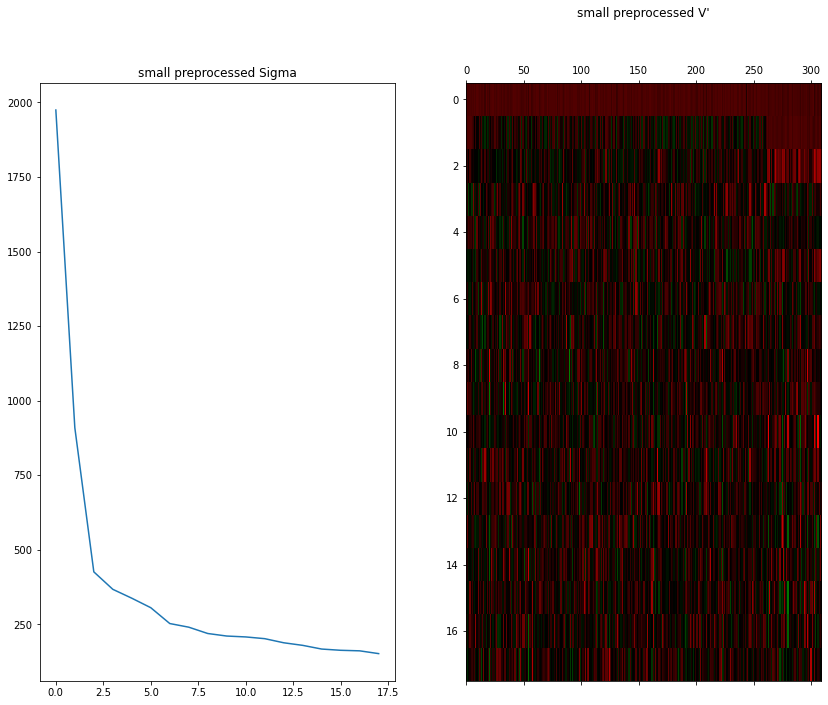

In [5]:
# taking a closer look at the outputs - reducing to 18 patterns
UsTZUsmall = UsTypeZU[:,0:18]
VsTZUsmall = VTsTypeZU[0:18,:]
SsTZUsmall = SsTypeZU[0:18]

# visualizing the closer look
plt.matshow(UsTZUsmall,cmap = cmap1, aspect = 'auto')
plt.title("smaller preprocessed U")
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.plot(SsTZUsmall)
ax1.title.set_text("small preprocessed Sigma")
ax2.matshow(VsTZUsmall,cmap = cmap1, aspect = 'auto')
ax2.set_title("small preprocessed V'",y=1.1)
fig.set_size_inches(14,11)

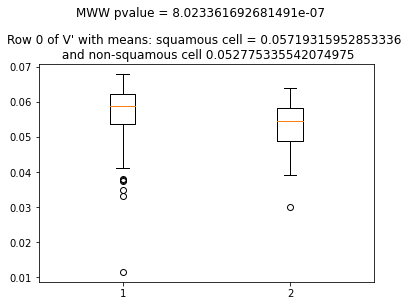

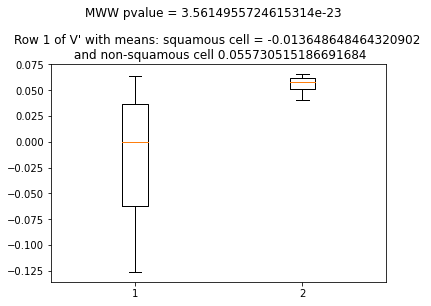

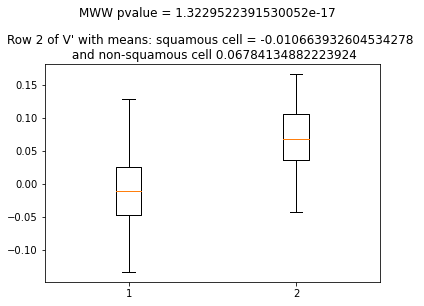

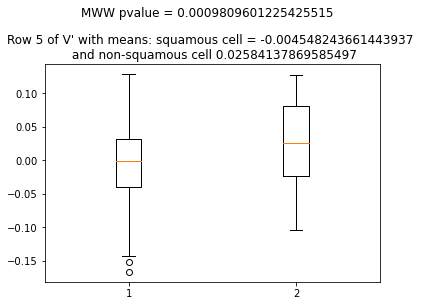

In [6]:
# Define the number of patients within each classification
typeLabelsSpacing = [6,255,28,3,17]

# for loop to calculate the pvalues of the rows present in smaller VT - index of those pvalues below a threshold (0.001)
# will be saved
kruskp = [None]*np.shape(VsTZUsmall)[0]
count = 0
indP = [0]*np.shape(VsTZUsmall)[0]
for x in range(0,np.shape(VsTZUsmall)[0]):
#   defining the different classifications and which columns fit within them
    type0 = VsTZUsmall[x,0:typeLabelsSpacing[0]]
    type1 = VsTZUsmall[x,typeLabelsSpacing[0]:
                       typeLabelsSpacing[0]+typeLabelsSpacing[1]]
    type2 = VsTZUsmall[x,typeLabelsSpacing[0]+typeLabelsSpacing[1]:
                       typeLabelsSpacing[0]+typeLabelsSpacing[1]+typeLabelsSpacing[2]]
    type3 = VsTZUsmall[x,typeLabelsSpacing[0]+typeLabelsSpacing[1]+typeLabelsSpacing[2]:
                       typeLabelsSpacing[0]+typeLabelsSpacing[1]+typeLabelsSpacing[2]+typeLabelsSpacing[3]]
    type4 = VsTZUsmall[x,typeLabelsSpacing[0]+typeLabelsSpacing[1]+typeLabelsSpacing[2]+typeLabelsSpacing[3]:
                       typeLabelsSpacing[0]+typeLabelsSpacing[1]+typeLabelsSpacing[2]+typeLabelsSpacing[3]+typeLabelsSpacing[4]]
    h, kruskp[x] = stat.kruskal(type0,type1,type2,type3,type4)
#   if statement that only saves indices if pvalue is below chosen threshold
    if kruskp[x] < 0.001:
        indP[count] = x+1
        count = count+1
#   removing uneeded elements in indP
    numP = np.count_nonzero(indP)
    indBox = indP[0:numP];
#   convert the indices back down to real value - was increased to allow use of count nonzero
    indBox = [x - 1 for x in indBox];

# investigating the same patterns as above using MWW and boxplots
for x in indBox:
    type0 = VsTZUsmall[x,0:typeLabelsSpacing[0]]
    type1 = VsTZUsmall[x,typeLabelsSpacing[0]:
                       typeLabelsSpacing[0]+typeLabelsSpacing[1]]
    type2 = VsTZUsmall[x,typeLabelsSpacing[0]+typeLabelsSpacing[1]:
                       typeLabelsSpacing[0]+typeLabelsSpacing[1]+typeLabelsSpacing[2]]
    type3 = VsTZUsmall[x,typeLabelsSpacing[0]+typeLabelsSpacing[1]+typeLabelsSpacing[2]:
                       typeLabelsSpacing[0]+typeLabelsSpacing[1]+typeLabelsSpacing[2]+typeLabelsSpacing[3]]
    type4 = VsTZUsmall[x,typeLabelsSpacing[0]+typeLabelsSpacing[1]+typeLabelsSpacing[2]+typeLabelsSpacing[3]:
                       typeLabelsSpacing[0]+typeLabelsSpacing[1]+typeLabelsSpacing[2]+typeLabelsSpacing[3]+typeLabelsSpacing[4]]
#   concatenate the non squamous cell types
    notType1 = np.concatenate((type0,type2,type3,type4))
#   find the mean of the groups to know how expression is affected (over vs under)
    meanT1 = np.mean(type1)
    meanNT1 = np.mean(notType1)
    u,MWWpvalue = stat.mannwhitneyu(type1,notType1)
    fig, ax1 = plt.subplots(1)
    ax1.boxplot([type1,notType1])
    fig.suptitle(f"MWW pvalue = {MWWpvalue}", y=1.08)
    ax1.set_title(f"Row {x} of V' with means: squamous cell = {meanT1} \n and non-squamous cell {meanNT1}")

In [7]:
# comparing the 2nd columns of each U matrix, prior to preproccessing and post processing, to see the affect on which genes are
# over/under expressed - this will be done by comparing the sorted list of gene names and counting differences

UsTypeGenesZU = np.concatenate((geneName,UsTZUsmall),1);
# create a copy of the geneNames + U matrix so that sorting will not affect the original matrix
UsTypeGenesSortZU = UsTypeGenesZU.copy()
# sort in both ascending and descending order by the 3rd index which is the 2nd column due to placement of gene names
UsTypeGenesSortAscZU = UsTypeGenesSortZU[UsTypeGenesSortZU[:,3].argsort()]
UsTypeGenesSortDescZU = UsTypeGenesSortZU[UsTypeGenesSortZU[:,3].argsort()[::-1]]

# print the genes so they can be copy and pasted into GOrilla - descending in this cell and ascending in the next
sortGenesAscZU = UsTypeGenesSortAscZU[:,0]
sortGenesDescZU = UsTypeGenesSortDescZU[:,0]
    
#this is the loop that counts the number of matching genes for sort order
# diffGene = [None]*geneName.shape[0]

# for x in range(0,geneName.shape[0]):
#     if sortGenesAsc[x] == sortGenesAscZU[x]:
#         diffGene[x] = 0
#     else :
#         diffGene[x] = 1
        
# numDiff = np.sum(diffGene)
# print("The number of genes in a different position after sorting is:",numDiff)
# print("")

# # print the sorted gene names for input into GOrilla
for x in range(0,geneNames.shape[0]):
    print(sortGenesAscZU[x])
    # commented out for print/export purposes as 20k lines is too many

KRT17
KRT5
KRT14
KRT6A
HSPB1
S100A2
SFN
KRT16
MT2A
RPLP1
GAPDH
RPS17
LGALS7
RPL8
RPS18
RPL35
ENO1
SPRR1B
LY6D
KRT13
KRT15
NDRG1
KRT6B
RPL35A
RPS16
FABP5
RPS29
MT1X
PI3
LGALS7B
RPL30
RPL36
TMSB10
RPS19
RPS3
CALML3
SPRR1A
RPL11
RPS5
RPS8
COL17A1
RPS24
RPL31
NTS
RPL27
RPL38
RPS15A
RPL18
KRT6C
?
H19
S100A10
PERP
CSTA
RPS2
TXN
RPL7A
RPLP0
RPS6
GSTP1
LGALS1
RPL4
S100A11
MIF
ALDOA
TRIM29
RPL13
IFI6
S100A14
PKP1
TGFBI
JUP
RPL24
SLC2A1
KRT1
ISG15
RPS15
FGFBP1
PLP2
AKR1C1
NDUFA4L2
CSTB
RPL12
RPS4X
RPL37A
HSPA1A
AQP3
FLNA
AKR1C2
RPL17
PABPC1
PKM2
LYPD3
FSCN1
CD9
RPL23
CLDN1
RPL13A
RPS20
RPL28
ANXA8
RPS10
LOC642587
DSP
TUBA1C
ATP1B3
ANXA2
RPL41
GPNMB
RPL10A
RPL37
SDC1
SERPINB5
RPL5
RPS21
DSG3
KRT4
RPL6
GPX2
FBL
TNFSF10
IGFL1
MMP10
NME2
TUBB6
RPS7
GJB2
GNB2L1
DSC3
RAN
KRT10
S100A16
RPS14
EIF5A
TACSTD2
DMKN
TYMP
PYGL
SBSN
RPS9
CSDA
AKR1B10
RPS27A
TP63
SPRR2E
SPRR3
TUBB
IFI16
MMP1
KRTDAP
MSN
LDHA
NACA
CXCL14
RPL3
PLS3
MYC
FN1
CDH3
CLCA2
SPRR2A
EEF2
GSTM1
LAMC2
ANXA1
PRNP
GAS5
CAV1
MMP14
SPRR2D
PTMS
G

NT5DC3
WHAMML2
ACSBG1
C3orf50
SCARNA1
GPC2
C1orf187
FAM163A
OVCH2
OR7A5
DKFZp761E198
MRPL50
EBF3
NLRP10
TMEM191A
ATP2B4
KBTBD8
TYRO3
CDK9
HIST1H4C
HIST1H2AJ
RAD51AP2
LOC401010
DPYSL4
FAM151A
ZNF560
ZBTB11
GRIN2A
TUBAL3
AQP7P1
SEZ6L
PCNX
FABP9
AMELX
CLCA1
PTPN5
DBC1
CUL1
PNMAL2
ZNF773
HTR7P1
CLEC5A
LOR
GABRG3
RAPSN
CREG2
MRAP
FAM13C
ZNF518B
C10orf140
GPR111
NKX1-2
GRIN3B
GPATCH3
TIPIN
CRP
MTMR2
DISP2
PROS1
DPP9
BLZF1
CORO2B
SCARNA14
THSD7B
LOXL4
NPTX1
EPHA6
FAM184B
HULC
BCAS3
FGF13
NKX3-2
SAAL1
RADIL
TAF5
FCRLB
TMPRSS15
SNORA14B
SNORA55
EYA3
ZBTB33
HIST1H3I
SFTPA1
LCE3C
RAPGEF5
GJC1
ITLN2
L2HGDH
EMR1
XRN1
SUN3
CENPE
SLC7A5P1
AMMECR1L
ASIP
ZNF772
LMX1B
RAB3B
C1orf161
KNG1
TMEM88B
MAFA
ADAMTS3
HOMER1
C6orf122
RNF165
SYNPO2L
SEMA5A
ELSPBP1
IL28A
SHE
SNORA26
XKR6
MGC12916
PCDHGA8
CNIH2
C20orf197
CXorf51
NRCAM
VWC2
KCNA7
LMAN1L
MID2
ZNF460
FRS2
ZNF549
KRTAP3-2
SLC6A17
NOL9
IL1F10
SLC25A28
SLC17A7
GALR2
SCN1A
SYK
LRRN4
STRA8
C19orf29
SNORD8
HIST1H2BM
NODAL
CEND1
TMEM74
TMEM160
NOBOX
HSF5
SGTB

MBD3L1
CXADRP3
PCDHGA12
SLC7A5P2
METTL12
ELAVL3
FAM66A
CD300E
LOC285796
PRINS
CCDC87
C7orf34
FOXD4L6
PPP1R3F
NAP1L2
C7orf16
HFM1
C1orf105
ZIC4
CSRP3
COL6A6
TREML1
PCDHB6
KIAA1409
CLDN25
PKIA
C11orf94
CAPN11
GRIK2
CBLN4
RBM44
KRTAP10-4
PTPRVP
TMEM105
ATP5L2
FBXW12
SLC32A1
TG
CYP3A7
PRSS42
CATSPER1
DRD1
C7orf51
KCNQ1DN
NMBR
BAI3
BREA2
?
LOC340508
MBOAT4
FILIP1
ST8SIA3
CPO
ASAH2
CYP2A7
MLNR
ZNF536
HMGCLL1
FAM183B
EBF2
CYMP
PCDHA9
KCTD16
CASR
C15orf50
UROC1
ANP32D
LDHAL6B
OR52N4
BFSP2
SLC45A2
ATP2B3
LOC100268168
TMPRSS9
LOC283867
FAM186A
SPATC1
PCDHGB3
AKAP3
SH2D7
C19orf35
KCNC2
RNF133
C20orf200
NANOG
AANAT
PCDHB1
PLA2G12B
CRYAA
SLC5A11
LOC401387
NYX
ROPN1
PCDHB18
ANGPTL7
ELANE
C10orf82
TMCO5A
LOC283392
PRX
NAP1L6
PPYR1
THRSP
NBPF4
LOC55908
WNT9B
RNF17
LOC285733
POM121L9P
LOC341056
GP5
MMP21
BTN1A1
CSMD2
HIST3H3
ACOT6
ASFMR1
KRTAP5-9
FAM9A
TMEM31
TRIM71
C1orf229
RAB40AL
LOC339674
GNRH2
LOC168474
RPL21P44
SLCO1C1
TEX12
POU1F1
CEACAM18
NXF5
ACR
CNR2
UBE2NL
CNPY1
WFDC8
GAPDHS
SEPT14
CRYBB2
PA

SLC25A22
SPIRE1
C17orf82
CCK
HIST2H2AC
ZNF630
LOC100272146
RAD54L2
SYS1-DBNDD2
CCL13
INTS2
NRM
GALNT9
POMT2
FMNL2
LRRC4C
AOX1
LOC400657
KIAA0754
ZNF398
DNAJC27
TNFRSF13C
GCOM1
C1QTNF3
SELP
WBSCR17
STRC
ZNF563
SLC26A7
RBP2
PREX2
KCNJ16
MED13L
ZNF230
GSG2
MEIS3
ASB1
C14orf28
CA14
EFR3B
LOC400927
ZNF765
INHBE
PRG2
ARPP19
ZNF654
ZNF202
HMX2
INE1
MST1P9
LRP3
C20orf165
RCE1
PRPH
ZNF286A
DNLZ
C13orf30
INHA
DOC2B
ZC3H3
ZNF490
FLJ10661
KIAA1211
DNAH11
CTH
DPEP2
CAPS2
UCP3
LOC100240734
PANK2
ZNF815
TIGD6
CRISP2
ZMYM1
ZKSCAN2
CEP170
MYO9A
MIPOL1
IKBKG
PLEKHM3
MCART1
SCARNA15
STOML3
GUSBL1
ASF1A
ZNF763
ZNF610
RIMS4
TMEM194B
GPR3
IRX6
KIAA0586
GPHA2
ZNF616
SATB2
CCDC41
RNMT
FOXRED2
ZNF180
USP25
RHOJ
ZFP112
IGLON5
PUS7L
APLNR
CHRFAM7A
RBM45
RAVER2
SLA2
IPCEF1
ADO
CCT6B
HOXA2
ATG10
TIMM22
ZNF449
COLQ
TFEB
ADARB1
TLR4
DMPK
KMO
HLX
HAR1B
LOC100125556
GK3P
SFRP5
RSPO3
CA5B
GNMT
MPP2
DCST2
CLPB
FOXM1
ZBTB3
RNF44
AS3MT
ZNF350
GUSBP3
MAGOHB
MPHOSPH9
ATF7IP
ITPKB
GPR65
RBM18
MDN1
C5orf35
DNAH12
RICTOR
ATP1B

SLC2A13
RTN4IP1
PGR
SNORA31
DTX2
CCDC33
SH2B3
PODN
TTC26
UNC119B
DDIT4L
KLRK1
CCDC93
LYPD1
TMEM192
CERKL
ZNF675
HERC3
BRD3
CCNA2
RASL12
HAGHL
HIST1H3G
WDSUB1
ARHGAP9
ODF2L
GGA2
HFE
SETD1B
FMNL1
CARD16
CYP2C18
SALL4
PRRT3
TNK1
ZNF248
ACTR8
ARHGEF18
PPFIA3
DCLRE1C
NPM2
AMICA1
FANCG
ZNF204P
APOM
FBXO38
CDK12
LIPT1
KIAA1530
ZNF275
CTSW
METTL2B
NFKB1
RIT1
HINFP
KHNYN
PTEN
CCDC109B
SLC25A33
EYA4
FPR1
SMTNL2
CYB5D1
NBPF15
HRSP12
KDM4C
SCNN1G
MIOX
SNN
ATP13A2
MESP2
SFRS15
KCNIP3
PCSK6
WDR33
EDNRA
CSNK1G2
RMND5A
CASC1
FOXO1
CPLX1
PDE4C
EPHA10
PTPRS
SGOL1
SLC23A2
DMRTA1
MKNK1
KIT
ZC3HC1
SHH
SERPINB9
C3orf38
C19orf61
RNF170
HTT
HOXB13
SYT13
DNAJC24
MED22
OPLAH
CD93
KIAA1841
IGSF6
PHF14
NEB
FRAS1
PAK1IP1
CWF19L1
RAB24
SNORD97
RCOR2
TIRAP
RABEP1
RBP5
NECAP2
CLYBL
TRIB3
SAMD12
C1orf104
SETX
CCNK
SLC15A4
ZNF329
PGBD2
NBN
L1CAM
RNF32
TRIM56
DOLK
NXF3
NFATC3
ANKS1A
GPD1
MMP24
CLASP2
RCHY1
RAI14
ACVR1
SLC25A45
THAP6
CITED1
LIG3
C12orf36
XRN2
MSX2
C19orf12
PRELID2
ARMCX5
FGD5
CPPED1
ZNF496
RGP1
KCTD17
AN

BLVRA
PBX1
DGCR6
CNNM3
C17orf70
FLJ35776
AGFG2
GOLGA3
GCFC1
CAMK2D
BCAT2
RBBP9
ACLY
TEP1
TRABD
TCTN2
FAM104B
ARFGEF2
PCSK1N
CC2D2A
SRP72
LCN15
MESDC1
MYB
FNBP1
DLD
VPS39
NPAS2
TMED6
SEL1L
GPT2
POLE
NUDT14
AAAS
TJP1
CYP24A1
NOP10
C14orf1
CAMP
TTC9
LOC100286793
LGALS8
LIMCH1
ARSE
RASSF6
LOC729678
CACNB3
THTPA
MRPL12
GATA2
YIPF4
FXC1
GAL3ST1
HAT1
GCNT1
FAM118B
NPIP
PARM1
UBE4A
ZMAT5
LSM10
PLCL2
ARL3
CRLS1
TMTC4
WASL
TESK1
SRCAP
MAPK9
CTDSPL
KIDINS220
IQCK
RABL2B
GCC2
CLDN23
LNX1
NPTN
RHOBTB2
FAM134C
RPAIN
PSD4
RAB36
BOC
CACNB1
AIG1
CTPS2
MCAT
CSTF1
DCK
AKAP9
CORO2A
WHSC2
SYTL4
ZMYM3
DYRK2
CCDC106
LOC388152
FAM98A
FAM36A
SEC22C
C6orf64
TIMELESS
FAM46A
ERMP1
SIAE
GPT
PHF23
HLTF
SUV420H1
MIPEP
PDS5A
NPTXR
CC2D1B
BAIAP2
SUDS3
PYROXD2
INPP5J
MADD
SLC25A25
ACYP1
PRAC
GYG1
ALDH3A2
RUNX1
PVRL3
SREBF1
SLC28A2
COL2A1
?
PPP1R2
ANKRD22
TTC7A
ZNHIT3
BTBD6
DTX3
DGCR2
METTL13
CBS
SDC2
STIM2
AAGAB
MSI2
C3orf39
ZNF580
GNPTAB
SMG7
RPS6KA1
C12orf52
CCDC53
RWDD1
RNF157
C1orf27
UACA
DOK7
LPIN1
LOC100288778
IF

TMPRSS2
SUCLG2
U2AF1
PRPS2
AHCYL1
RPS13
RAB11FIP1
PODXL
GPR160
C1orf210
ARF5
CCDC104
CLDN10
GPC4
PSMB9
MPDU1
TUFM
EPS8L2
H1F0
ISYNA1
PTP4A1
SEC22B
WDR6
COPB2
TMEM98
NME3
GSDMD
AK1
SFRS6
LPCAT1
ACY3
ALDH3B1
PPP1CA
PAFAH1B3
SFRS11
ACSL5
AMY1A
HN1L
HOXB2
ACSF2
C9orf24
HNRNPAB
YPEL3
ARSD
MLF1
TRAPPC1
DDRGK1
MCM3
PTPN18
PYGB
RHBDD2
TPD52
UBXN1
SLC35B1
CAPNS1
MRPL53
TAF10
MAL2
GTF2IP1
SRI
GMPPA
SFRS2
HSD17B4
B4GALT5
CMTM7
MORF4L1
FAM195B
TRAF4
UBE2D3
SH3YL1
NASP
LRIG1
TMPO
HOXB7
MAGEF1
CTSC
SEC16A
ARRB2
GTF3C6
PPCS
ST3GAL4
ARPC4
VILL
FUS
TRNP1
PHYHD1
NDUFA5
AUP1
MT1F
BRP44L
TMEM179B
CDH1
RCN1
SHMT1
UQCRFS1
ANXA3
WBSCR22
LUC7L3
GALNT12
DPP7
SDF4
CHP
INF2
AK2
RNPEPL1
PRKCSH
ARCN1
KCNN4
SEPHS2
UQCRQ
WBP1
VKORC1
NUDC
HYOU1
ISG20
HGD
XRCC5
LMNB1
MPST
GJB1
FADS2
CDH16
SCOC
VPS28
HNRNPL
ASF1B
MEIS1
GALNT3
LXN
GABARAPL2
GLB1
C6orf108
AKT1
VTCN1
PSMB6
AHCY
HNRNPC
STRA13
SLC25A29
STRA6
CNPY3
ADAM6
OLFM4
RNF167
CD68
G6PC3
ST6GALNAC4
C1orf194
NET1
ORMDL3
S100A1
KIF22
C21orf59
SURF4
HDHD3
SKP1
CRELD2
ABH

In [8]:
# Sorting columns 1 and checking it in GOrilla as it is the most significant row in VT after preprocessing to zero mean unit var

UsTypeGenesZUc1 = np.concatenate((geneName,UsTZUsmall),1);
# create a copy of the geneNames + U matrix so that sorting will not affect the original matrix
UsTypeGenesSortZUc1 = UsTypeGenesZUc1.copy()
# sort in both ascending and descending order by the 3rd index which is the 2nd column due to placement of gene names
UsTypeGenesSortAscZUc1 = UsTypeGenesSortZUc1[UsTypeGenesSortZUc1[:,2].argsort()]
UsTypeGenesSortDescZUc1 = UsTypeGenesSortZUc1[UsTypeGenesSortZUc1[:,2].argsort()[::-1]]

# print the genes so they can be copy and pasted into GOrilla - descending in this cell and ascending in the next
sortGenesAscZUc1 = UsTypeGenesSortAscZUc1[:,0]
sortGenesDescZUc1 = UsTypeGenesSortDescZUc1[:,0]

# print the ascending sorted gene names for input into GOrilla
# for x in range(0,geneNames.shape[0]):
#     print(sortGenesAscZUc1[x])
# commented out for print/export purposes as 20k lines is too many

S100A8
S100A9
KRT5
KRT13
KRT14
HSPB1
KRT6A
KRT16
S100A7
CSTB
SFN
S100A2
PI3
SPRR1B
LY6D
SPRR3
SPRR2A
SPRR1A
LGALS7
FABP5
KRT6B
CSTA
CALML3
KRT15
FABP4
RHCG
SPRR2D
LGALS7B
KRT6C
ANXA1
?
SPRR2E
SERPINB3
AQP3
S100A11
LYPD3
S100A14
TACSTD2
C4orf7
NDRG1
SERPINB4
PERP
GJB2
SBSN
CRABP2
KRTDAP
S100A16
CALML5
CNFN
TRIM29
DSG3
JUP
SDC1
PKP1
HBB
IL1RN
MT1X
LOC642587
C10orf99
PITX1
TYMP
KRT1
SLC2A1
IVL
IFI16
CLCA2
TMPRSS11D
SERPINB13
DSC3
NDUFA4L2
KRT4
ANXA8
APOL1
TMEM45A
GJB6
FGFBP1
DSP
AKR1B10
KRT10
SERPINB5
IL20RB
SPINK5
RHOV
TGM1
SPRR2F
TNFSF10
ECM1
A2ML1
ZNF185
DSC2
FAM83A
NCCRP1
PVRL4
MAL
CRNN
CENPW
KLK13
LAD1
ATP1B3
PDZK1IP1
TP63
PVRL1
PROM2
SOD2
APOBEC3A
CLCA4
EMP1
CA2
?
CRCT1
SPINK7
GNA15
S100A12
PPL
GM2A
TMPRSS11A
TMEM79
LCE3D
FAT2
C9orf3
CDKN1A
SPRR2G
EPHX3
IL1F9
CGA
ANXA8L2
GPR87
TUBA4A
CLTB
PRSS27
MPZL2
ZNF750
CRYAB
CDH3
PLAT
KLK10
GJB5
CLEC2B
IRF6
KRT24
GRHL3
SERPINB2
FAM25A
MALL
SLURP1
FGFR3
THBD
DUSP7
HES2
SPRR2C
GLTP
SPP1
GBP6
CASP14
DEFB4A
SOX15
EPHA2
C9orf169
DUOX2
ZNF385A
SGK1


FAM24A
MYH6
PDHA2
OR5K1
C20orf185
PLGLA
ADAM7
PRDM9
LCE3B
OR8G5
OR4F5
GOLGA8F
VENTXP1
OR1A1
OR13D1
OR14A16
CCDC105
TRIM60
?
APOL5
IL9
OR6M1
OR4S1
C21orf54
OR1I1
DEFB107A
SLC17A6
OR2G3
FLJ25328
UBE2U
DEFB129
OR4F4
C1orf141
APCS
OR2T11
OR52A1
OR5AN1
LCE4A
OR4S2
CELA2A
SSTR4
CETN1
C11orf64
PRPS1L1
SLC36A3
MRGPRX1
LOC390858
OR2AK2
IFNA10
FOXD4L5
OR5L2
TMEM225
OR5B21
OR7A17
IL3
OR10K2
OPN1MW
IQCF5
ACTL7A
C9orf27
OR4K1
DAOA
KRTAP4-8
ZIM3
CSPG4PY2
SSX3
C4orf11
OR9A4
OR11A1
OR52M1
SPATA19
TSPY3
OR7G3
C20orf79
LOC339568
OR6N1
PRM1
ADAD1
OR5K4
TMPRSS12
FAM194B
OR8B4
OR6B1
OR5B17
OR4C12
OR51T1
OR7G1
POTEC
OR8I2
POTEB
CDX4
OR9I1
CYLC1
OR2Y1
FAM138D
OR8G2
OR1A2
OR51F1
SLC7A13
BEYLA
OR6P1
OR6C75
OR5T1
HES3
C10orf96
OR10J3
OR4F17
NCRNA00185
MBL2
LOC285370
FLJ44082
C14orf53
FSHR
OR2J2
DEFB136
OR4C3
GK2
OR6N2
LACRT
OR1L4
OR9G9
DEFB132
OR2L8
PPP1R3A
OR56A4
USP17L6P
?
?
?
OR51A4
OR4C45
OR52E8
OR51S1
GLYCAM1
KRTAP25-1
OR5AK2
LOC653545
OR51L1
OR51G2
OR4K13
FAM41AY1
OR5H1
OR5D14
CDY2B
OR51D1
OR5H15
BPY2
FAM

SLFN14
RBMXL2
CCDC54
GJD4
CPLX4
MIMT1
SNORA51
TEDDM1
KCNS2
C2orf78
BANF2
LOC440040
PATE2
ZNF80
CFHR2
NEUROG3
OR1C1
MUC7
ZNF804A
ZNF679
CALHM1
SULT2A1
METTL11B
ZP2
CRYGC
OLIG2
C3orf65
FAM19A1
GSX2
MSH4
PIP5K1P1
SLC35F4
IGLL1
A4GNT
TAS2R3
TRIM67
IQCF3
MRGPRG
LOC285045
UPP2
VGLL2
GABRA1
PTCHD3
TPI1P3
C14orf115
LOC91948
RBM46
AWAT2
KCNA7
LYZL4
PATE4
OR1Q1
TMCO2
OR1J1
CDCP2
T
LOC653786
NAA11
C3orf24
FAM153C
NUP210L
RFPL3
MC5R
SVOP
C1orf87
ALLC
PGA5
GPR61
RIT2
DAZL
OSTN
OR5AU1
TSNAX-DISC1
DLGAP2
OR1F2P
LOC400940
PTPRQ
NKAIN3
RPA4
YIPF7
BTG4
HTR4
AICDA
CDK15
GCNT7
LOC730668
ZAR1L
NPY5R
MYF6
C2orf51
PXT1
SLC9A11
KRTAP5-6
IL17F
STL
TRDN
C10orf27
LPPR5
MCART3P
IL2
C10orf71
MORC1
MYH7
GPR45
RFX6
MMP20
GJA3
ACTN3
IFNA1
TMC3
HAO2
LOXHD1
LOC150568
IFNA13
ASPDH
C8orf12
RBP3
CELA3B
C9orf131
NCRNA00159
TGIF2LX
CTXN2
S100Z
CAPZA3
IRGC
C14orf70
KRTAP2-4
CA6
OR2C1
SLC9A10
MYBPHL
ETV3L
LOC731789
FGF22
LOC283856
PRG1
ANGPTL5
C10orf62
PROKR1
CCDC42
NLRP14
ANGPTL3
LOC339240
C17orf98
TAS2R46
ENTHD1
ZCCHC5
TRPV

GABRA5
SHC4
PABPC5
C16orf3
LOC728989
C4orf38
SLCO1B1
GABRR2
IL18RAP
GAD2
LOC401127
C21orf129
PSD2
PCDHGA2
PLA2G5
C4orf26
DPF3
CALN1
CNTF
FAM153A
PCDHGA5
EGOT
DKFZp434J0226
MIXL1
APOA2
FAM7A2
UCMA
C1orf229
HGC6.3
UTS2
ATP4A
KIAA0748
DBH
GBA3
HCN4
SSX6
ASB14
PZP
C6orf58
TNFSF8
NELL1
ESRRB
ARSH
FXYD7
PAGE2
NXF2B
CD28
GPR55
PARP15
CDKL4
PCDHGB6
CSN2
CNGA2
GCG
PURG
SLC16A6
AZU1
SLITRK3
LRRC69
MYL4
LTA
CA7
SHANK1
POTEF
TAS2R19
C8orf45
FLJ37307
GRID2IP
LRRC52
LHX4
MCART6
NCRNA00202
C1QL3
LOC441454
HILS1
PCDHGB4
PTTG2
C10orf68
RPS26P11
TEKT5
GABRG3
BPI
IGSF5
TAF1L
MGC14436
ST8SIA5
STOX2
CALML6
NHEG1
NMUR1
CDKL5
NLRP6
LOC285548
CELF3
ADCYAP1
CES4
WNT8B
SNORA77
KCNA3
RABGGTA
RPL31P11
C22orf43
C2orf73
CAMKV
NRSN1
MARCH11
ECT2L
CASP12
PIK3R6
DNAH17
CNGA4
NOL4
HCN2
C9orf128
ZBTB20
NTN3
SNORA42
CALCA
RUNDC2C
C1orf101
ZNF536
B3GAT2
C6orf174
GPR113
ATP8A2
HRH2
CPA2
KCNC2
ZNF658
GPR123
NOX3
KRT73
IGFBP1
CD86
ZNF257
CRYAA
KCND2
C10orf140
RGS18
SNORA56
APOBEC4
THEG
C17orf78
AVPR1A
SHBG
PAR5
C22orf31
PRDM

WSCD2
TACR1
ZNF883
KYNU
OTUB2
NTNG1
SNORD1C
SYNGR4
NEUROG2
FIGNL2
SIGLEC15
SNORA7B
IL2RA
FKBP1AP1
RGAG1
SPN
PPAPDC3
BMP5
SYPL2
CALHM3
SLC35F3
TUBA3C
CNTN2
AOC2
HIST2H2BA
AR
LOC121838
PLAU
DNASE1L2
FAM41C
CA10
EFCAB6
YPEL4
AKAP6
ADAMDEC1
FRMPD1
PTGER1
KCNN1
FAM57B
EFHA2
TM6SF2
NPY1R
CACNA2D4
THPO
ZNF385B
TAS2R14
CDKL2
ACTC1
GPR77
HIST1H3C
MTMR7
LRRC24
FOXR2
FMN1
PNPLA3
DIO3OS
KIAA1755
MLC1
NANOS3
ZNF671
FAM40B
ZNF442
SLC6A2
SNX30
C8G
CD96
TMEM132C
GATA5
ADAP2
TRPC4
C1orf158
CBR1
CA4
C10orf114
C10orf54
KLHDC1
FLRT2
LOC401010
LOC341056
CHRM3
DAND5
IGSF1
IL17REL
PCDHA6
NOVA2
MGC3771
CACNA1B
FGD2
GSTA2
RAB9B
C10orf12
ZDHHC15
EREG
KDM4D
MKRN3
CLEC18C
ANKRD44
ITK
ACE2
IKZF3
KCNK13
GIPC3
SP9
FAM155A
LOC145783
SLC5A9
ZNF772
DBC1
C11orf20
SNORA78
SOX5
TRIML2
MYH3
ZCCHC18
LOC149837
ROR1
NEDD4
PRKG1
FRG2C
C6orf164
C13orf38
SERPINI2
TLX2
HIST1H2AH
LAIR2
DISP2
AFF3
LRRC66
C3orf36
FAM92B
SEC14L4
FUT1
LMX1B
ZG16
LOC283174
SRL
LOC402377
MGC23284
ADCY1
ZNF737
?
TMEM191A
TRPM8
KRT40
CD101
SCARNA7
PLAC4
C

ZNF518B
AOX1
ZNF497
NAMPT
EFNA2
NXF3
YSK4
CASC2
COLQ
LOC284440
CEP97
HPCA
ZNF225
KLRG2
ARL8B
HIC2
ST6GALNAC5
ZNF449
NKX2-5
FANCM
C14orf72
LOC100130093
ZNF85
ENKUR
TUB
MAML3
CLCN5
ANKRD1
KRT222
THAP9
SLIT1
TCF21
ZBTB3
APOB48R
C3orf62
HAS1
ZNF684
OSBPL3
TSPAN32
FLJ40330
PHACTR3
SNORA5A
KRBA2
CLEC1A
TNFSF13B
CECR7
APOOL
ARRDC4
EVI2A
LRRC33
ZNF137
NRIP1
ZNF714
FAM65C
ADSSL1
PCDHB9
ZNF521
BEGAIN
GABPB2
SLAMF9
NNAT
LAIR1
GPD1
CD6
NPFF
OTOS
GBGT1
ZSCAN22
RNASEL
KIAA1644
NHEDC2
CYP4F11
ZNF461
LOC100302650
ACRBP
TLR4
SLC16A11
C3orf47
CHRFAM7A
ZNF347
BHLHA15
LOC647946
LOC100128288
ADAMTSL3
FAM117B
LOC153684
CYP2A13
TNFRSF10A
INMT
PRDM5
TBX19
SNPH
NCRNA00115
ANGPTL1
TTLL9
XAGE2
C6orf118
HIST2H2BF
PAR-SN
PRICKLE4
DNM3
GAGE12J
ZNF813
ANKRD45
PAGE4
ZNF169
KIAA1919
ITGAL
FLJ43663
GARNL3
LRRIQ1
LOC100130987
UGT2A3
SNORA49
ERCC4
C12orf27
LRRC29
NCRNA00107
INO80D
FKBP9L
FNDC1
ZNF19
CCDC33
KCND1
RUNX2
GRM8
PDE10A
PKIA
MTMR9
NBPF3
TLR1
DHRS9
MSTN
C1orf173
ZKSCAN2
DCLK2
OXTR
TNFRSF17
SERPINA6
LOC642826
C16

FAM200A
PAX2
TNFAIP8
WDR78
HGF
ADAM19
CHST11
RNU11
TM4SF20
FNDC4
MTX3
TPCN2
C6orf167
C17orf76
MTHFR
FBXL17
SCTR
TOX2
RILP
C22orf30
INTS2
NOD1
SPI1
IRX2
IFIH1
EGR3
C18orf19
GPRASP2
PCOTH
COX6B2
DDIT4L
MACROD2
LRRC56
NWD1
MAST3
AQP7
CHRNA1
PGBD2
SAMD4A
RAB43
ENHO
SLC16A9
ZNF341
CACNG6
THBS4
ZNF18
CNNM2
METTL4
ELTD1
GNG12
C2orf50
GTF2A1
ZNF799
PNCK
KIF24
URB2
PRRT1
BBS5
HLX
FGD3
CTH
ZBTB34
MTM1
ZNF541
SEMA6C
PVRIG
TMEM20
S1PR1
RNF160
MTERF
RELT
ZNF138
POLK
SUCNR1
GMEB1
PRKAA2
DENND5B
USP42
GPR161
IL17RA
MIPOL1
DHDH
C7orf60
OTUD6B
SH2D2A
SETDB2
FBXO41
LINGO1
TMEM102
ACCN2
KREMEN1
ZNF41
FOXF1
IL12A
OLFML1
FPGT
DMRT3
SPATA18
OR2A7
CHST4
C18orf18
STK10
ZBTB6
LATS1
KIF3A
RPAP2
SERINC5
SNORA20
TRAF3
ZNF10
ZNF192
SPATA6
CYTL1
BCDIN3D
STYX
SCNN1B
FAM120C
FAM105A
NAPB
C19orf39
PLD6
STAG3L1
NEURL3
AASDH
DYNC2H1
SNORA64
GJC2
ABI1
CHST15
TEKT1
BRIP1
ZNF506
DEPDC7
ZNF34
ZNF101
FGF18
HIST1H2BG
DDC
TMEM55A
RABL3
PGBD1
C11orf63
RASEF
NEU4
CCT6P1
GALNTL4
NEXN
SNX22
CLDND1
SCFD2
COL8A2
KIAA0922
YAF2
SLC25A

CLIP3
INO80C
NEIL1
CCDC42B
SIKE1
PPFIA3
ACSL1
SNORA8
EXO1
GCH1
ZSCAN21
NRP2
C15orf61
TOE1
C4orf42
BRAP
NUP155
MTO1
EXD3
GPR137B
NDEL1
C10orf78
SMCR7
HSD17B14
CORO2A
SDPR
RAB3IL1
C4orf41
TAOK3
GPR124
ZNF434
UAP1L1
MRAS
DHX57
ASPM
SVIL
EPN3
LOC100130776
GPA33
SLC29A3
CIITA
HNF1B
NCRNA00094
SESTD1
ZNF408
MVK
TTLL1
STK11IP
SRBD1
SLC19A2
ATP8B2
ODF2L
MARK4
NLN
SBF2
FAM134B
PTPRM
ALKBH3
ZNF784
MAN1C1
C9orf21
ALKBH4
KIAA1462
DYRK2
CAMK2G
PKD1
C4orf33
WBP4
RASA3
AARS2
DCP2
KLF16
FUT6
MEG3
AK3L1
CUL2
SALL2
ZIC2
HYLS1
NBPF9
FBN2
OSGIN2
METT10D
RNF219
FOXC1
C19orf12
NICN1
ZNF589
ACOX1
CSPP1
MDM1
RASSF9
ZNF655
PTPN22
LETM1
ZNF592
OSR1
HSF4
C16orf52
LYN
RELL1
AMMECR1L
ZFP106
GORAB
ALS2
RNF212
VAMP1
CUL9
KDM6B
HOXB13
MBP
MIOS
LOC144438
MED13
CENPQ
NCF4
ZNF532
CAPN7
VPS41
C6orf223
C21orf58
XRCC6BP1
SERPINB9
SHISA2
CEP63
DOCK7
POLG2
FBXO17
MRI1
ATG7
KDM4B
PASK
DSCR6
FAM119A
TMEM41A
SC4MOL
ADK
C1orf50
IMPACT
BLOC1S3
RNF122
PLEKHA3
RAP1GAP2
C7orf70
EAF1
TTLL4
DPT
PDS5B
FLT1
MLLT10
MIER2
BPIL1
SETX
ARNT2

EIF4G3
GCA
LRRCC1
KPTN
RAB18
SLC35A5
SEPT10
GOSR1
UNC119B
ZFP64
TAF6L
KIAA0247
PPP3CA
NFRKB
RNFT1
SPC24
CSRP2BP
RRP8
DEFA6
PEX2
OSBPL5
CTU2
PPP1R3B
NCBP1
KCTD13
GEMIN4
RALGAPB
KIAA0776
PAPD7
SLC4A1AP
IFIT1
IPO9
YTHDC1
HSPA13
THTPA
FOXP1
CCDC25
STAU2
DOLK
NVL
SIPA1L3
SLC4A11
ARHGEF11
CTR9
IQSEC2
SUPV3L1
ANKS3
LIMD2
GZMA
WIPF1
DHRS11
VNN2
ZBTB22
STS
ACSM3
NAGK
PHAX
RB1
MPPE1
SULT1E1
CYTSA
PPP1R14A
MAVS
GLB1L
OLFM2
B3GALT6
KATNA1
RRAS2
TMBIM1
PARVB
TCF4
CASP8
TRNAU1AP
NF2
DCAF16
ZBTB12
FBRSL1
KIAA0556
C22orf29
ZNF193
MED7
MED14
KIAA1109
CWF19L1
JDP2
ZCCHC11
WIZ
RIPK1
KITLG
ARHGAP26
SUSD2
HEATR1
DDX10
NOXA1
PRPF39
PIGK
CHD6
HKDC1
TMEM116
KHNYN
LRWD1
MKS1
ZNF226
FAM131A
SNAP29
TMEM25
ATF2
ANKMY2
ZBTB4
CA5BP
FTO
XAF1
TRAPPC2P1
ENPP5
COL14A1
PTGS2
NPTXR
FBXL3
C1orf133
RPAP3
WDR12
BCKDHB
NR2C1
VSTM2L
C1orf212
SPON1
NYNRIN
DDA1
THNSL2
RHOU
NFKBIB
ABCB7
PIP5K1C
SLC25A14
ASPN
DHX36
ALG14
SLC15A3
ARMC1
ARHGEF18
EPDR1
TTC39C
TMEM8B
RTP4
HIBCH
TRAFD1
FKBP15
ULK1
PHF20
WAPAL
MEI1
EFR3A
CDCA4
FAM20B
M

TNKS1BP1
TNFRSF19
SRCAP
DHX34
FTSJD2
MICA
FAM20C
FAM108A1
C17orf70
BZRAP1
NCKIPSD
TXNDC15
UTP3
LGALS2
C21orf63
CXorf40A
SFXN3
DHRS4L2
ALDH8A1
RECQL4
FYTTD1
FAF2
CPSF6
TTC38
C5orf49
TFPI
BAIAP2
NUP43
C16orf91
FDXR
GLIS2
BPNT1
ABT1
TOX3
DVL2
ARAP1
JMJD6
H2AFJ
THUMPD1
TOX4
MCF2L
OSBP
TMEM216
TMOD3
DUSP16
ATP6V1B1
TMEM132A
UBE2B
RANBP9
TNFAIP1
IGFBP6
ZFP62
SLC44A3
PPP1R2
PRAP1
SCMH1
FCF1
STK39
ATG5
TSNAX
LIF
CHEK1
AP4B1
GPATCH4
CPSF4
GFER
ALPP
FRAT2
PGM3
MYST2
LOC729082
VAPB
WIPI2
RPRD1B
ALG12
CHSY1
MTIF2
RPRD1A
CD47
HNMT
BEX2
MTMR12
RFC1
SEPT8
C1QTNF6
SPA17
TMEM69
CNPY4
BRF1
TPCN1
MPZL1
ERCC2
BSPRY
KIAA0090
NUDT8
PLCXD1
CHMP6
GMFB
TMX1
CAD
LIPA
SEH1L
CMTM4
WDFY1
LDB1
CCDC94
TARS2
COX4NB
ETNK1
RABGAP1
MAPKAPK5
MYOF
NIPBL
SLC25A37
TBL2
EIF2B3
NCAPD3
PTRH1
ATL2
LEPROTL1
BCS1L
TNIP2
DNAJC2
SEC23A
GOLPH3L
MAPK13
SMAP1
EEF1A2
C7orf49
AKAP13
SFRS2B
CES1
CHRAC1
AP1M1
EED
MUS81
PPIL4
WDR26
L3MBTL2
LOC728554
KIAA1543
GBA
RFX5
NR1H3
SLC37A1
C1RL
ZNF330
SAP30
MTERFD1
CYP27A1
GADD45G
SNX7
C20orf72
PRP

CASP7
LMO4
SMTN
LOC151162
SRP72
COPS8
SNX1
MGRN1
SUN2
MATN2
USE1
RBM25
TMEM30B
DCAKD
DEDD2
LRRC45
SERPINE2
DLG5
RAB4B
PLRG1
SPTBN2
CNP
PTPRK
KAT5
PCM1
KIAA0146
RBM22
CHPF2
CLDN10
PCBP4
PITPNB
MYO6
NXN
PDE6D
MAPKAPK2
C19orf77
LOC728855
MSX1
C21orf45
ZMYND11
FAM100A
GSTM1
C7orf68
LTB
SLC9A1
TMSB15A
CCDC74A
TFAM
SLC11A2
DNAJC12
TNFRSF6B
C3orf75
SAR1B
RACGAP1
RAB25
ICMT
SOD3
CRIM1
GALNT1
SELT
FAM158A
CCDC34
CMAS
BAT2L2
EMID1
CISD2
ANKLE2
MRP63
APOO
PECAM1
MRPS14
GPBP1L1
TSPAN17
SMEK1
KIF9
HDAC3
BCLAF1
GGNBP2
MAP1LC3A
CIAPIN1
IL1R2
GGT7
EGFL7
FGFRL1
ATP9A
RERE
MITD1
MTX2
KIAA0195
DDX54
ASCC2
PAK1IP1
F2RL1
SLC22A18
FAM54B
EIF3J
METAP2
C16orf48
PPP1R16A
OSGEP
CHKA
GSTM4
FAM120AOS
PEMT
MOAP1
TMEM126A
FOXP4
NSUN5P2
KIAA0907
ITFG1
IVD
SUPT6H
SLC37A4
ZNF581
FANCI
IWS1
GNPDA1
DOK4
HRAS
C11orf73
MRTO4
HAUS7
TBC1D7
PAAF1
IL2RG
PRPS1
TOR1A
DDX19B
NUP98
PSMD9
UBE2V2
APPL2
C17orf101
ZNF131
SP100
MKKS
BAIAP2L2
CDT1
TYK2
PPM1B
GOLIM4
FSTL3
DIDO1
ASL
GPR89A
CCDC28A
SERTAD1
FAM168B
HPCAL1
NEK6
AFG3L2
LRRC4

INSIG1
TSPAN4
DKC1
LGMN
POP7
ADAM9
UBE2N
G3BP1
MGC29506
GATM
DARS
SOX9
MAN1B1
MRPS16
COPB1
RAD23B
SPTBN1
TMEM30A
LFNG
CANT1
AP3D1
S100A1
DNMT1
HIST1H2AC
AKR1B1
BAG1
MCM4
COQ4
MRPL4
TWF2
XIST
LUC7L
PKIG
BNIP3
FAM192A
C2
HADH
AMZ2
TCF3
ACTR1B
DHPS
TRA2A
IER3IP1
RBM8A
MUC6
HYAL2
RNPEP
GMPPA
LIMA1
CHMP1A
IMP3
NOC2L
PMPCB
MT4
DLST
C11orf48
ATP6V0D1
MPV17
RGL2
GPR172A
GAA
PHF10
GNS
LAMC2
TRIM8
MCRS1
PXDN
SULF1
CPE
GLT25D1
NFU1
APCDD1
CCL20
SCARB2
DAG1
CDK2
NAT14
TMEM97
OBFC2B
LMNB2
SHMT1
AIFM1
PRR15
CPSF3
CREB3L4
FASN
MCM6
SMARCA4
ARL1
MTA1
NRBP1
CPD
ARHGEF1
QTRT1
FGFR1
TSN
MRPS2
MLF1
NT5C3L
POLE3
UBTF
LOC440957
MLLT6
LAP3
PEPD
UGDH
TARS
PHYH
PTGR1
ASPH
CTNNAL1
PRPF8
ANP32E
MMP13
SAMM50
PLTP
NUDT5
ALPPL2
EMG1
MRPS12
CTHRC1
CCDC47
SFRS18
ARAF
SGTA
CLN6
RAB20
TPRKB
PLA2G2A
C1orf57
ZNF358
CDK1
ZNHIT3
RBM5
POLR3K
TMEM8A
SLC25A11
DERL2
TCEAL3
CDKN2C
PAK4
RNF220
UQCRB
C19orf6
PXMP2
PSMC6
ZNF638
PEF1
HSPG2
PSMC2
PTGDS
ZFAND6
ATP6V1G1
TSG101
NUP62
SAT2
C16orf42
TMEM111
SFRP1
MOGS
C9orf78
TCIRG1
PRMT

CSDE1
HLA-E
ARPC5
C6orf108
ITM2B
SNRPA
DCI
NDUFA7
PSMA3
TMEM14B
MRPL12
NUCB2
PPM1G
TAF15
AKR1C2
HIST1H2BK
C20orf3
FAM50A
APH1A
TMEM176B
RAD23A
COL18A1
SERPING1
SNRPD3
RNPS1
CCT4
TUBA1C
NGRN
MMP2
DCN
APOA1BP
CCT2
POLE4
UFC1
SSB
LGALS4
VKORC1
C17orf49
WDR1
KIAA1324
DDIT4
PSMA1
AEBP1
HNRNPUL1
CDK5RAP3
TCEAL4
BCL2L1
GNB2
PAM
GPRC5A
HSPA9
C20orf24
VASP
YWHAH
SUMO1
RPL7
AHSA1
F3
MCM3
ATP6AP1
YIPF3
KPNA2
HLA-DQB1
PLOD1
NBL1
ATP5J
GTF3A
GNB1
RTN3
HBXIP
RNASET2
RBM4
PTBP1
ENY2
COPZ1
MRPS24
MAT2A
CST1
HNRNPM
CDC37
NDUFS3
NEAT1
CTSA
XRCC5
SDHA
C20orf30
TK1
NDUFV2
BAX
ISYNA1
JTB
MRPL27
SKP1
RPS28
TRAM1
FAM96B
PSMC4
ETFB
NDUFV1
CCT8
UQCRFS1
PFDN6
NDUFA12
CD99
RNF181
ARPC4
ILK
NASP
DEK
PAFAH1B3
TSPAN13
CAPG
CNPY2
MRPL14
TMEM66
RUVBL2
SELENBP1
CYB5R3
PSMB2
SNRNP70
LRPAP1
VAMP8
C9orf16
CDK2AP2
QSOX1
UBXN1
SFRS5
NHP2L1
FXYD3
SEC13
FIS1
NME4
PNKD
ATP6V0B
SCAND1
PKN1
AGR3
PSMC3
HNRNPF
ATHL1
CDK2AP1
PRDX3
ADRM1
TRAPPC1
NDUFAB1
RNASE1
SPCS1
MYH9
TMEM219
HNRNPU
COX7A2L
MGST1
AUP1
C12orf62
POLR2H
MYH14
ERGIC

In [9]:
# print the descending sorted gene names for input into GOrilla
# for x in range(0,geneNames.shape[0]):
#     print(sortGenesDescZUc1[x])
# commented out for print/export purposes as 20k lines is too many

TMSL3
WFDC2
RPLP1
RPS11
TPT1
S100A6
RPS18
GAPDH
RPL37A
TMSB10
RPL41
RPL31
RPS6
RPS21
RPS29
RPL30
RPS17
RPS4X
ACTB
SLPI
RPS12
RPLP2
FTL
RPL35A
RPL8
RPS16
FTH1
RPS24
RPL19
KRT8
RPS3
RPL11
RPS8
RPL18
RPS14
EEF1A1
ACTG1
RPS19
MYL6
RPS9
RPS15A
RPL36
RPL35
RPL23
CD74
RPL38
RPL27
RPL3
RPL26
PTMA
CRIP1
KRT18
RPS20
AGR2
RPL24
RPL7A
IFITM3
RPS5
HLA-B
PFN1
RPLP0
GNAS
B2M
RPL5
ATP5E
RPS25
RPL12
RPL4
GNB2L1
TFF3
RPL29
RPL13A
RPS13
RPS27A
RPL13
CD63
HLA-A
MT2A
RPL10A
TUBA1B
LCN2
KRT19
UBB
FAU
MIF
KRT7
MUC1
LGALS1
COX7C
H19
RPS10
HLA-C
IFITM1
MDK
RPL28
PPIB
CALR
NME2
EEF1G
RPL14
RPS2
CFL1
NACA
TIMP1
RPS7
GSTP1
COX6B1
RPS15
TAGLN
HSP90AB1
RPL37
HSP90B1
PKM2
P4HB
TUBB
RPL6
ATP5I
CEACAM5
S100P
ENO1
RPL32
SSR4
EEF2
HLA-DRA
EPCAM
EDF1
RPL34
SPINT2
MGP
VIM
LGALS3
RPL10
ALDOA
NDUFS5
PFDN5
RPL17
CLIC1
CALM2
CST3
TXN
PPDPF
NCRNA00188
SLC25A6
PTMS
NPM1
RPL36AL
LGALS3BP
COX6C
LDHB
TPI1
COX4I1
RPL15
TSPAN1
BTF3
MYL12B
HSPA8
H2AFZ
HSP90AA1
PIGR
UBL5
BSG
OST4
COX6A1
ATP5G2
EEF1D
H3F3A
IFITM2
COX8A
ROMO1
UBC
RPSA
T

SMN2
TRIM47
IMP4
RBM6
FLYWCH2
GPC4
TMEM14A
RAVER1
C19orf2
CCNB2
HOXB7
TRIP6
PRMT5
TCIRG1
C9orf78
MOGS
SFRP1
TMEM111
C16orf42
SAT2
NUP62
TSG101
ATP6V1G1
ZFAND6
PTGDS
PSMC2
HSPG2
PEF1
ZNF638
PSMC6
PXMP2
C19orf6
UQCRB
RNF220
PAK4
CDKN2C
TCEAL3
DERL2
SLC25A11
TMEM8A
POLR3K
RBM5
ZNHIT3
CDK1
ZNF358
C1orf57
PLA2G2A
TPRKB
RAB20
CLN6
SGTA
ARAF
SFRS18
CCDC47
CTHRC1
MRPS12
EMG1
ALPPL2
NUDT5
PLTP
SAMM50
MMP13
ANP32E
PRPF8
CTNNAL1
ASPH
PTGR1
PHYH
TARS
UGDH
PEPD
LAP3
MLLT6
LOC440957
UBTF
POLE3
NT5C3L
MLF1
MRPS2
TSN
FGFR1
QTRT1
ARHGEF1
CPD
NRBP1
MTA1
ARL1
SMARCA4
MCM6
FASN
CREB3L4
CPSF3
PRR15
AIFM1
SHMT1
LMNB2
OBFC2B
TMEM97
NAT14
CDK2
DAG1
SCARB2
CCL20
APCDD1
NFU1
GLT25D1
CPE
SULF1
PXDN
MCRS1
TRIM8
LAMC2
GNS
PHF10
GAA
GPR172A
RGL2
MPV17
ATP6V0D1
C11orf48
DLST
MT4
PMPCB
NOC2L
IMP3
CHMP1A
LIMA1
GMPPA
RNPEP
HYAL2
MUC6
RBM8A
IER3IP1
TRA2A
DHPS
ACTR1B
TCF3
AMZ2
HADH
C2
FAM192A
BNIP3
PKIG
LUC7L
XIST
TWF2
MRPL4
COQ4
MCM4
BAG1
AKR1B1
HIST1H2AC
DNMT1
S100A1
AP3D1
CANT1
LFNG
TMEM30A
SPTBN1
RAD23B
COPB1
MRPS16


GAR1
TNFAIP2
CLUAP1
UPK1B
MRPL19
CMC1
POLE
ALDH1B1
C15orf44
SAFB2
C5orf43
C9orf24
DERL3
CSNK2A1
YTHDF2
NAE1
PSMD12
CD2AP
ATP13A2
ASNS
TTC35
BCL7B
ZCCHC3
TTC19
ORC3L
EPS8L3
NADK
EIF2B2
ProSAPiP1
GPKOW
STAT2
LEPRE1
ZDHHC7
TCTEX1D2
SPAG5
HDDC3
RASIP1
UBE2D2
AURKA
HSD17B8
PIK3R3
YBX2
SENP3
WDR33
DDB2
CEACAM7
DYNC1H1
GTF2H4
CARKD
CIAO1
ATP6V0E2
CBWD3
SLTM
SPATS2L
PFDN4
GET4
PPIF
RAB11FIP1
TMEM44
HEXIM1
RGS1
UBL4A
ACAD9
HOXB8
PROSC
PRR24
IMPDH1
FARSB
LRRC42
AFG3L2
NEK6
HPCAL1
FAM168B
SERTAD1
CCDC28A
GPR89A
ASL
DIDO1
FSTL3
GOLIM4
PPM1B
TYK2
CDT1
BAIAP2L2
MKKS
SP100
ZNF131
C17orf101
APPL2
UBE2V2
PSMD9
NUP98
DDX19B
TOR1A
PRPS1
IL2RG
PAAF1
TBC1D7
HAUS7
MRTO4
C11orf73
HRAS
DOK4
GNPDA1
IWS1
FANCI
ZNF581
SLC37A4
SUPT6H
IVD
ITFG1
KIAA0907
NSUN5P2
FOXP4
TMEM126A
MOAP1
PEMT
FAM120AOS
GSTM4
CHKA
OSGEP
PPP1R16A
C16orf48
METAP2
EIF3J
FAM54B
SLC22A18
F2RL1
PAK1IP1
ASCC2
DDX54
KIAA0195
MTX2
MITD1
RERE
ATP9A
FGFRL1
EGFL7
GGT7
IL1R2
CIAPIN1
MAP1LC3A
GGNBP2
BCLAF1
HDAC3
KIF9
SMEK1
TSPAN17
GPBP1L1
MRPS14
PECAM

LOC147727
BRCA1
REXO4
HGSNAT
FAM193B
CADM1
BDH2
IFRD1
ANAPC7
HNRPLL
PLEKHA6
TAF12
LOC729678
LIX1L
SLC26A6
CCDC130
ISCA1
DYRK1B
DNAJB12
KIF11
C6orf203
SIRT2
FHOD1
TIMM22
HEATR2
TMEM53
B9D2
DNM1L
FXR2
B4GALNT3
MAPK8IP1
BYSL
ALG2
NT5C3
SFRS8
MIA3
CDC42EP3
MSX2
IQCG
USP9X
PCSK1N
RBM7
SLC12A9
PTDSS2
FMNL2
SP1
VAPA
TSPAN33
IGF2R
NOL6
C6orf1
FNDC3A
ACO1
CCL21
PLEK2
NUPL2
RBBP6
GTPBP5
CD40
HBP1
SHROOM3
C18orf55
NDC80
SKIV2L
PATL1
GOLGB1
SEL1L
TFE3
C7orf36
RGS5
EFTUD1
SLC7A8
NDUFS1
TMEM175
RAB15
TFCP2
SRXN1
PPIL3
C11orf54
BBS2
KLHL12
BIN3
C16orf88
HSBP1L1
C20orf112
MYCBP
CENPK
UBA5
ERP44
DMPK
UCK2
STK36
IFT46
HMGCS2
C2orf68
ANKRD54
NUS1
TMEM189
SIAH1
ZNF3
ACD
CHGA
LRCH4
RHPN1
FAM49B
RNF115
ALS2CR4
HERC2
TTC9C
STAP2
RAB3GAP1
SFXN1
GRTP1
UBAP2
CLDN12
DDX55
GEMIN7
TRIT1
ATP8B1
TMEM80
CMAH
KIAA0652
POFUT2
RSU1
DOCK6
DEAF1
MAGED4B
GINS1
POLR1E
B3GNT7
LRP4
IBTK
DAK
SLC35F2
GFM1
CHKB-CPT1B
STC1
MT1A
SLC16A5
C4orf14
NTN4
TMED5
NUP160
ZMYM3
TNPO2
HSCB
C6orf211
XPO7
LGR4
CCDC19
ARHGEF16
GAS1
GGT6
SIRT6
P

MEI1
WAPAL
PHF20
ULK1
FKBP15
TRAFD1
HIBCH
RTP4
TMEM8B
TTC39C
EPDR1
ARHGEF18
ARMC1
SLC15A3
ALG14
DHX36
ASPN
SLC25A14
PIP5K1C
ABCB7
NFKBIB
RHOU
THNSL2
DDA1
NYNRIN
SPON1
C1orf212
VSTM2L
NR2C1
BCKDHB
WDR12
RPAP3
C1orf133
FBXL3
NPTXR
PTGS2
COL14A1
ENPP5
TRAPPC2P1
XAF1
FTO
CA5BP
ZBTB4
ANKMY2
ATF2
TMEM25
SNAP29
FAM131A
ZNF226
MKS1
LRWD1
KHNYN
TMEM116
HKDC1
CHD6
PIGK
PRPF39
NOXA1
DDX10
HEATR1
SUSD2
ARHGAP26
KITLG
RIPK1
WIZ
ZCCHC11
JDP2
CWF19L1
KIAA1109
MED14
MED7
ZNF193
C22orf29
KIAA0556
FBRSL1
ZBTB12
DCAF16
NF2
TRNAU1AP
CASP8
TCF4
PARVB
TMBIM1
RRAS2
KATNA1
B3GALT6
OLFM2
GLB1L
MAVS
PPP1R14A
CYTSA
SULT1E1
MPPE1
RB1
PHAX
NAGK
ACSM3
STS
ZBTB22
VNN2
DHRS11
WIPF1
GZMA
LIMD2
ANKS3
SUPV3L1
IQSEC2
CTR9
ARHGEF11
SLC4A11
SIPA1L3
NVL
DOLK
STAU2
CCDC25
FOXP1
THTPA
HSPA13
YTHDC1
IPO9
IFIT1
SLC4A1AP
PAPD7
KIAA0776
RALGAPB
GEMIN4
KCTD13
NCBP1
PPP1R3B
CTU2
OSBPL5
PEX2
DEFA6
RRP8
CSRP2BP
SPC24
RNFT1
NFRKB
PPP3CA
KIAA0247
TAF6L
ZFP64
UNC119B
GOSR1
SEPT10
SLC35A5
RAB18
KPTN
LRRCC1
GCA
EIF4G3
ME3
NOV
RAD1
YEATS2


KDM6B
CUL9
VAMP1
RNF212
ALS2
GORAB
ZFP106
AMMECR1L
RELL1
LYN
C16orf52
HSF4
OSR1
ZNF592
LETM1
PTPN22
ZNF655
RASSF9
MDM1
CSPP1
ACOX1
ZNF589
NICN1
C19orf12
FOXC1
RNF219
METT10D
OSGIN2
FBN2
NBPF9
HYLS1
ZIC2
SALL2
CUL2
AK3L1
MEG3
FUT6
KLF16
DCP2
AARS2
RASA3
WBP4
C4orf33
PKD1
CAMK2G
DYRK2
KIAA1462
ALKBH4
C9orf21
MAN1C1
ZNF784
ALKBH3
PTPRM
FAM134B
SBF2
NLN
MARK4
ODF2L
ATP8B2
SLC19A2
SRBD1
STK11IP
TTLL1
MVK
ZNF408
SESTD1
NCRNA00094
HNF1B
CIITA
SLC29A3
GPA33
LOC100130776
EPN3
SVIL
ASPM
DHX57
MRAS
UAP1L1
ZNF434
GPR124
TAOK3
C4orf41
RAB3IL1
SDPR
CORO2A
HSD17B14
SMCR7
C10orf78
NDEL1
GPR137B
EXD3
MTO1
NUP155
BRAP
C4orf42
TOE1
C15orf61
NRP2
ZSCAN21
GCH1
EXO1
SNORA8
ACSL1
PPFIA3
SIKE1
CCDC42B
NEIL1
INO80C
CLIP3
KLF9
KIAA0947
SDHAP2
SHOC2
PRELP
C3orf14
SP5
FZD5
MBNL2
LRSAM1
C9orf6
ANK3
CACNB1
SNX27
SYT7
SLC25A32
DDX51
TRIM68
SESN1
QRSL1
HIP1
CSNK1G3
C17orf71
FBXO31
C14orf169
ACCS
E2F3
ASAP1
PHLDB2
OPA3
SAMD10
MITF
LOC728613
RNF6
KBTBD6
APAF1
CTF1
ZNF761
PIBF1
ZNF627
NRBP2
HPS4
RNF166
CCDC88A
GREB1
ABC

WDR52
ZNF28
INS
S1PR3
ZSWIM4
MTMR6
CEMP1
XPNPEP3
USP30
ASB9
C2CD4A
TOR1AIP2
SNX18
KLHL18
GPHA2
CD8A
GIMAP5
SLC25A40
BOD1L
ALOX5AP
CTNS
CD27
B3GALTL
TLN2
MPV17L
FOXO3B
SH3BP2
KIAA2026
VTI1A
TMEM135
LOC653653
RRAGD
ADCK1
NAF1
ADNP2
ANKS4B
CES3
ZNF281
CDADC1
SGK223
RICH2
DMXL1
IRGQ
DOT1L
SLC38A6
MDFI
HOXC11
SYDE1
FLT3LG
FOXJ2
ZMYM5
ZNF320
DCHS1
TMTC2
RC3H2
ZNF600
TP53INP1
TFAP2C
ETV7
LOC388692
ATP9B
LOC200030
ZNF165
C9orf103
TRIM59
CCDC60
SCML1
SLC16A14
FANK1
NCRNA00085
ZNF473
FAM113B
CPOX
LDHD
IKBKAP
KIF20B
C1orf130
ROR2
SEMA3A
SLC35E3
TANC2
EMB
CDON
TRO
ESCO2
PDSS1
C12orf24
FAM119B
MANEA
RAB10
RRP7B
DOPEY1
RXRA
HUS1
C17orf68
PDZRN3
RPL23AP82
CCDC146
UHRF1BP1
ZNF69
SGOL2
UBASH3B
TTPAL
CD48
SYNGAP1
DNAJB13
RCOR1
CHGB
TMEM211
KCP
PLAC9
KCNH3
HTR3A
SCARF2
NFIA
CCDC18
TRIM52
ZUFSP
PI16
LOC285074
LOC441089
KIAA0831
LOC92659
SLC25A15
ZNF211
CSGALNACT1
ZNF526
CTTNBP2NL
ACVRL1
SRPX2
NSUN3
PON3
DUSP8
DIXDC1
DEF6
LRP12
FRS3
NR2C2
SHPK
C5AR1
WDR67
ZC3H10
IFIT2
CWF19L2
RTN4IP1
DNAJC24
CCDC76
TWIST2


PLEKHA9
LOC162632
EID2B
HOXC5
PVT1
SLC24A1
ZBED3
CYP20A1
C20orf134
ZNF654
ZFP30
GLT25D2
SH2B2
ITGB2
JAM2
RSPH4A
GLYATL3
LOC100132247
LOC401052
JMY
ANGPT2
AFAP1L1
ZFP41
ZNF436
CCRL2
FUT10
PITPNM3
PIH1D2
NMNAT1
ELAC1
EP400NL
?
DIP2B
IKZF4
NAT8L
VASH2
KIAA0513
KIAA1530
MAPK4
FEM1B
USP27X
POPDC3
ANKRD9
USP35
SH2D3C
FRK
ATF7IP2
MAGEC2
LOH12CR1
ZBTB46
LOC400927
HIST1H4E
MAP9
PMS2L4
EXPH5
GRAP
ZFYVE9
ADPRH
SACS
MFAP3L
THSD1P1
ZNF17
RSC1A1
LRIG2
PTPLAD2
BVES
FLI1
HPSE
NCRNA00120
ZNF420
RIT1
SNORA37
ROPN1B
ZBTB39
ZNF273
SRCIN1
ADAMTS7
ZNF324B
PCDP1
CENPI
ABCA11P
CHST1
SNORA21
FAM19A5
KIAA1529
ZNF880
PIWIL4
ZNF462
ZNF510
ZNF175
SLC10A7
RNF32
IGSF10
ANKRD12
PLEKHA8
PIPSL
LAMA2
BFSP1
ZNF57
EPM2A
TAOK1
DLX1
FAM45B
MARCH3
ADORA2B
MAT1A
EPHA10
KCNMB3
LRRN4CL
ITGA4
WSCD1
MST1P2
LOC100132707
DDX60L
MARCO
C17orf103
C6orf165
ZNF334
GEMIN8P4
C20orf118
NACC2
AKR7L
UNC5A
SCGB1D1
CELSR2
BTBD12
FAM133B
PTCD2
ULBP1
GPR110
FREM2
FAM169A
CBL
ZNF519
DYDC2
CELF2
C10orf72
SP4
RNU4ATAC
CLDN16
ANK1
NMNAT3
ADPRHL1
KIA

C8orf44
MKNK2
EPHA4
ARL9
LOC441208
LOC100144603
ZNF485
SNORD8
ENTPD7
ZNF793
APOA1
ARHGAP6
OVGP1
C1orf26
ROBO2
JAK2
HOXA4
ABCA4
OSGIN1
GPR155
CXCR6
ISCA1P1
PCDH12
ELOVL2
DOK2
LOC401431
LOC389333
CA14
RTN4RL2
AP3B2
PTH1R
DNAJC27
ARHGEF33
LOC100129387
CCL3L1
KCNIP1
PKNOX2
CYTH4
LOC645323
ZMAT3
CELP
CNTN4
PPFIA4
GPRASP1
LOC282997
SPDYA
MYRIP
RASAL3
ART5
PHEX
SRRM5
BDNFOS
HCFC2
CSN3
XRN1
INHBE
CCDC136
NEU3
SCARNA15
C17orf57
AQP12B
C17orf67
RAD9B
RASAL2
PHYHIP
KIAA1107
FBXL22
AKAP5
ZNF407
SCARNA8
PCSK2
APOBEC1
LOC391322
LOC100170939
KRTAP5-1
NCRNA00174
ZMYND12
KCTD21
KCNJ16
C12orf66
ADAMTS14
PSTPIP2
RNU6ATAC
VLDLR
LOC100272228
CYP2F1
PGBD3
LRMP
SLC7A9
ABHD6
PPM1F
CATSPERB
GABRD
HSPB9
GAGE2D
LOC643719
LOC148189
HYAL1
KAT2B
DNAI1
PDE1A
TNFAIP8L2
MYOM3
SNORA54
PCDHAC1
ANKRD23
BTC
BRCA2
TMEM170B
C7orf31
SGCD
C14orf105
FOXN4
TNFRSF13C
SOCS7
NEURL
TAGLN3
PCBP3
CCL23
SAMSN1
LOC728758
LHX1
C14orf174
RASGRP2
SFTPD
TCEANC
DPH3B
DYNLRB2
ZFP37
RNF150
PCDHB3
LY6H
CELF6
PRKCG
ANKRD36B
DMRT1
GRM4
BMPER
SGC

FAM55A
PHOSPHO1
SEC14L5
FNDC8
GRIN1
CRB2
TBC1D3G
ELOVL4
SHROOM2
TMEM84
LRRC15
PRICKLE3
LPPR4
KCNMB2
FABP9
LAX1
KIR2DL4
MTUS2
FIGN
TMOD2
NLRC3
CNR1
ACRC
POU2F2
LOC646471
MTMR8
USP49
GAS2L2
LOC92973
CCR2
TUBAL3
SNORA50
GABRB2
LOC389791
KCNT1
LRRK2
RFPL3S
SUGT1P1
BTBD17
HIST1H4B
SCN9A
SH3D20
OXT
SCARNA6
HLA-L
RPL23AP64
C2orf84
CCDC73
NCRNA00173
SPDYE6
ADAMTS17
TYRP1
ZNF389
ATP8B3
CR2
KCNJ10
FAM90A1
DGKG
TSSK4
HOXC13
ZNF546
PDZD7
TPH1
DIO1
DNAH3
DPEP2
MGC16703
TUBB1
GUCY1B2
SYCP2L
ZNF215
SPTBN4
CNTNAP2
CLCNKA
ABCA1
MS4A12
CRYBB3
MGC16142
HLA-DPB2
CACNB2
RAPSN
MGC4473
AGTR2
ZHX1
CCDC154
SLC6A13
LOC144486
KIR3DL2
NRK
C6orf124
GPR120
USP6
SCGB3A2
RAB39B
DGCR11
PAH
KIAA1875
CEND1
NCF1B
KLHL32
BTK
NCF1
FAM19A2
TMPRSS15
C20orf26
IBSP
PCDHB11
CACNA1A
DHRS4L1
GPR75
CLDN19
LOC650623
LRRN4
HRC
TRIM16L
FEZF1
LHFPL4
IDO2
MYLK2
SLCO5A1
KLRG1
SNORA5C
AQPEP
FHDC1
PIK3C2G
IRX6
FCAMR
CCDC7
NCRNA00086
SNORA28
RGS17
KCNA6
CLEC4E
C6orf155
CD209
LILRB5
ZSCAN12P1
TICAM2
FLJ10213
HIST2H3D
C20orf201
ANKAR
FIGF
ED

PKD1L2
NRG3
PAQR9
TREX2
MCF2L2
HSD3B2
KLF17
C14orf86
TGM7
MT1IP
SPATA9
SLC38A11
CDH8
LRRC4
TKTL1
ABCC11
DCD
APOH
UBE2NL
SNORD116-28
HOXB1
CATSPER1
MEGF10
LRRC67
SPATA4
DNTT
SH3TC2
HIST1H1A
AQP12A
KRTAP1-3
ZNF366
C8orf75
CHD5
P704P
MYBPC3
C22orf26
SOX3
MYO16
RP1
HEATR4
SLC4A10
WHAMML2
C10orf90
CGB2
DSG4
KCNK4
WBP11P1
AGBL3
SLC18A2
WDR87
DCX
ATP10D
SLC6A3
TMEM90A
LOC152225
IL5RA
GATSL2
EVX1
FLJ33360
TIMD4
HIST1H4L
AFARP1
TEX11
NOS1
TCTE1
P2RX6
KRTAP2-2
ISX
MAGEC1
MYH16
SCN2B
MYO18B
HTRA4
PIK3CG
TRIM53
ABCG5
CEP170L
C14orf68
SLC22A11
CLDN20
PPM1J
NR1I3
RFPL2
PLD5
CPEB2
THRSP
NRXN1
C17orf50
VSX2
TDRD6
ALMS1P
HIST1H1T
STXBP5L
NPHS1
ST7OT3
RAB41
GPR152
LRRC18
NEUROG1
DCAF12L2
LOC100129066
CDC14C
KRT84
UNC5D
ZNF492
PCDHGA1
CTRB1
KIAA1409
VSTM1
GRIP2
OR7C1
LOC441177
CPSF4L
KCNG2
ACSL6
CHRNB2
SLC30A10
ZBTB32
LRRC7
ANGPT4
FAM166A
GRIA3
CETN4P
APOBEC2
C9orf106
CXorf50B
XCR1
CHRNA3
GRIN3A
HIST1H2BB
MOGAT1
KRTAP11-1
CCDC116
BSX
PCDHGB5
OCM
FLJ32063
CD300LB
P2RY12
HECW1
C6orf218
ALS2CR12
LOC10027221

PMCHL1
CNR2
C14orf48
C15orf5
KDM5D
SLC22A7
SIRPB2
PBOV1
DEFB118
PRAMEF1
SLED1
XKR3
C14orf183
LOC729467
LOC100128023
C5orf52
SAG
FBXO47
GABRG2
GRID2
H2BFM
KCNV1
RPE65
C4orf40
C21orf96
SLC22A9
NKX2-6
CPXCR1
CT47B1
C4orf50
FAM123C
SDC4P
PRB4
NCRNA00052
CATSPER4
TPD52L3
AADACL4
KCTD4
SLC17A1
ANKRD55
VCX2
C4orf37
POM121L1P
TFAMP1
STARD6
MYL1
A2BP1
C4orf45
CYMP
DCC
MRGPRD
OR2A25
GPR151
LOC154449
GUCA1C
OR6B3
PRDM7
ZIM2
NOTO
LHX8
LOC643486
KBTBD13
TAS2R13
BRS3
GPRC6A
CT47A2
CELA2B
SEBOX
TMEM30C
CHRNA2
VCX3A
MMP27
KCNH7
FRMPD2L1
ADAM18
MYH2
CT45A6
TMEM14E
UNC13C
LOC150622
PRR25
OR51Q1
PANX3
OR1N1
CCDC63
KCNA4
OR52D1
C12orf50
FSD2
DSCR10
LOC100130148
IL4
FLJ40504
SPDYE4
ACTL6B
MCHR2
MS4A6E
LOC729609
TRPC7
GOLGA6A
OR1M1
OR6F1
FAM187B
CYP4A22
FOXB2
SLC36A2
BTF3L1
GIF
SLCO6A1
ASZ1
C20orf191
SNORA14A
NETO1
FAM170A
C3orf49
NCRNA00203
LOC148824
KCNA10
NCRNA00111
C7orf71
C17orf102
LOC151658
GSC2
LOC285847
AGXT2
AANAT
LOC643677
C15orf32
TAS2R42
NLGN4Y
C15orf54
BLID
LOC148696
PRAMEF5
SLC4A9
LOC100192379

OR7A17
OR5B21
TMEM225
OR5L2
FOXD4L5
IFNA10
OR2AK2
LOC390858
MRGPRX1
SLC36A3
PRPS1L1
C11orf64
CETN1
SSTR4
CELA2A
OR4S2
LCE4A
OR5AN1
OR52A1
OR2T11
APCS
C1orf141
OR4F4
DEFB129
UBE2U
FLJ25328
OR2G3
SLC17A6
DEFB107A
OR1I1
C21orf54
OR4S1
OR6M1
IL9
APOL5
?
TRIM60
CCDC105
OR14A16
OR13D1
OR1A1
VENTXP1
GOLGA8F
OR4F5
OR8G5
LCE3B
PRDM9
ADAM7
PLGLA
C20orf185
OR5K1
PDHA2
MYH6
FAM24A
CST9L
OR2A2
GOLGA8G
C17orf105
OR4D10
KCNK18
KRTAP4-2
LALBA
ANTXRL
IRGM
C9
FLJ25758
ACTRT1
MDS2
HIGD1C
OR8U1
KRTAP9-4
RNASE8
C19orf75
SULT1C3
G6PC
NF1P1
IFNA14
PPIAL4E
MS4A14
TAS2R41
SPAM1
PCNAP1
SLC6A5
CTXN3
LOC100188947
CST8
MAGEA5
C12orf40
TEX13B
DEFB109P1
PTPN20A
LOC285194
CTSL3
KRTAP13-1
LOC348840
CT47A1
POM121L4P
AKR1D1
GML
GYPB
FAM75A3
FAM75A5
C15orf2
ELAVL4
IL22
OR2T33
TCEB3B
FAM75A2
LOC283914
DEC1
C3orf79
LOC100130264
BMP10
OR2L1P
FAM90A7
ADAMTS20
IL25
OR2L13
KRT35
C20orf186
C4orf17
TRIM40
LOC729668
BOLL
MYH13
MAB21L2
ACTL7B
TACR3
MRGPRX2
FAM183B
NEU2
OR51B4
CLEC1B
C10orf113
KC6
GRIA1
C7orf33
CLEC12B
LUZP4
SIGLEC

In [157]:
#looking at squamous cell specifically 

# loading in Squamous cell only sorted by age
SqAge = pd.read_csv("/Users\Jordan\Documents\GitHub\PythonCode\Data Science for Engineers\BME6900 Cont\SqScaleSortAge2.csv")
SqAge = pre.scale(SqAge)
# Loading in Lung Squamous cell sorted by age
LungAge = pd.read_csv("/Users\Jordan\Documents\GitHub\PythonCode\Data Science for Engineers\BME6900 Cont\LungSortAge2.csv")
LungAge  = pre.scale(LungAge)
# loading in Female only Lung Squamous cell sorted by age
LungAgeFemale = pd.read_csv("/Users\Jordan\Documents\GitHub\PythonCode\Data Science for Engineers\BME6900 Cont\LungFemaleSortedAge2.csv")
LungAgeFemale = pre.scale(LungAgeFemale)
# load in Lung sorted by sex
LungSex = pd.read_csv("/Users\Jordan\Documents\GitHub\PythonCode\Data Science for Engineers\BME6900 Cont\LungSortSex.csv")
# load in lung gene names
LungGenes = pd.read_csv("/Users\Jordan\Documents\GitHub\PythonCode\Data Science for Engineers\BME6900 Cont\LungGeneNames.csv")

# select a representative set of Sq Cervical to pair with Lung - must be same number of columns
lungR,lungC = np.shape(LungAge)
fLungR, fLungC = np.shape(LungAgeFemale)
SqR, SqC = np.shape(SqAge)

fullSpacing = (SqC/lungC)
FemaleSpacing =(SqC/fLungC)

fullInds = np.zeros([1,lungC])
femaleInds = np.zeros([1,fLungC])

# select indices to distrubte across ages evenly
indCount = 0;
for x in range(0,lungC):
    indCount = indCount + fullSpacing;
    fullInds[:,x] = np.floor(indCount);
    
fIndCount = 0;
for x in range(0,fLungC):
    fIndCount = fIndCount + FemaleSpacing;
    femaleInds[:,x] = np.floor(fIndCount);   

# create subsets of the squamous cervical cancer data based off these indices
SqLungSub = np.zeros([SqR,lungC]);
for x in range(0,lungC):
    subInds = int(fullInds[0,x]);
    SqLungSub[:,x] = SqAge[:,subInds-1];
    
SqLungFemaleSub = np.zeros([SqR,fLungC]);
for inds in range(0,fLungC):
    subInds = int(femaleInds[0,inds]);
    SqLungFemaleSub[:,inds] = SqAge[:,subInds-1];
    
# np.savetxt("/Users\Jordan\Documents\GitHub\PythonCode\Data Science for Engineers\BME6900 Cont\LungAgePy.csv", LungAge, delimiter=",")
# np.savetxt("/Users\Jordan\Documents\GitHub\PythonCode\Data Science for Engineers\BME6900 Cont\SqAgeSubPy.csv", SqLungSub, delimiter=",")

Vt dim  (132, 132)


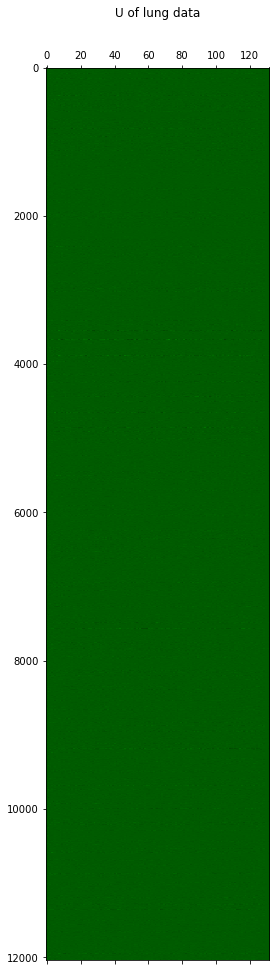

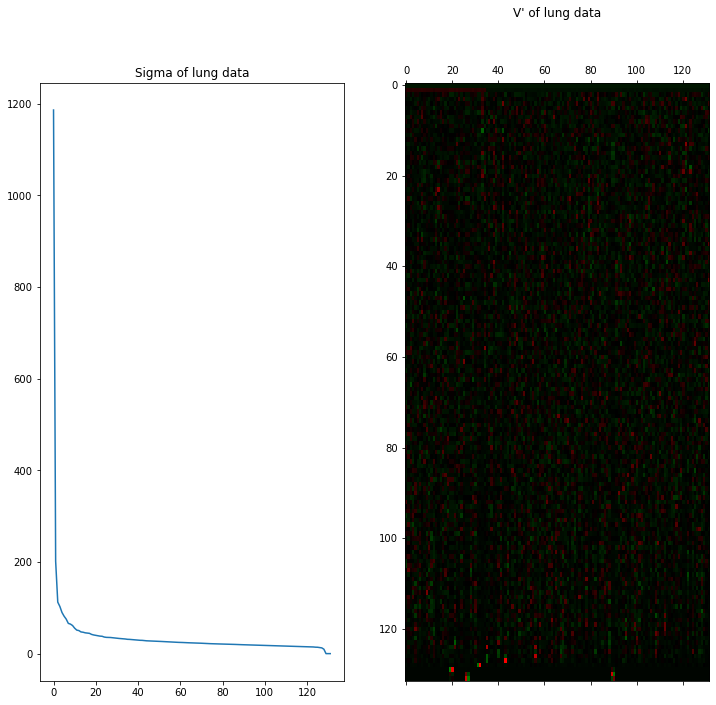

In [94]:
# recreate some of the data from last semester

# preprocess lung data to zero mean unitvariance
LungSexZU = pre.scale(LungSex)

UL,SL,VtL = np.linalg.svd(LungSexZU,full_matrices = False)

#rank is count of values above zero
thresh = 0.0001
rankSL = np.count_nonzero(SL > thresh)

# visualize the output of the SVD
plt.matshow(UL,cmap = cmap1, aspect = 'auto')
plt.title("U of lung data")
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(SL)
ax1.title.set_text("Sigma of lung data")
ax2.matshow(VtL,cmap = cmap1, aspect = 'auto')
ax2.set_title("V' of lung data",y=1.1)
fig.set_size_inches(12,11)

print("Vt dim ",np.shape(VtL))

Text(0.5, 1.0, 'Row 1 - Squamous Cell Lung Cancer sorted by sex')

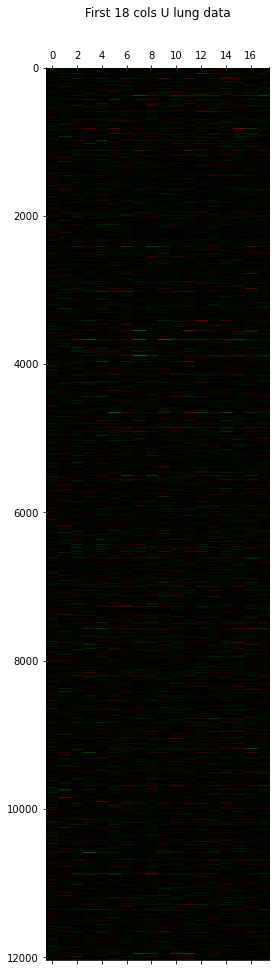

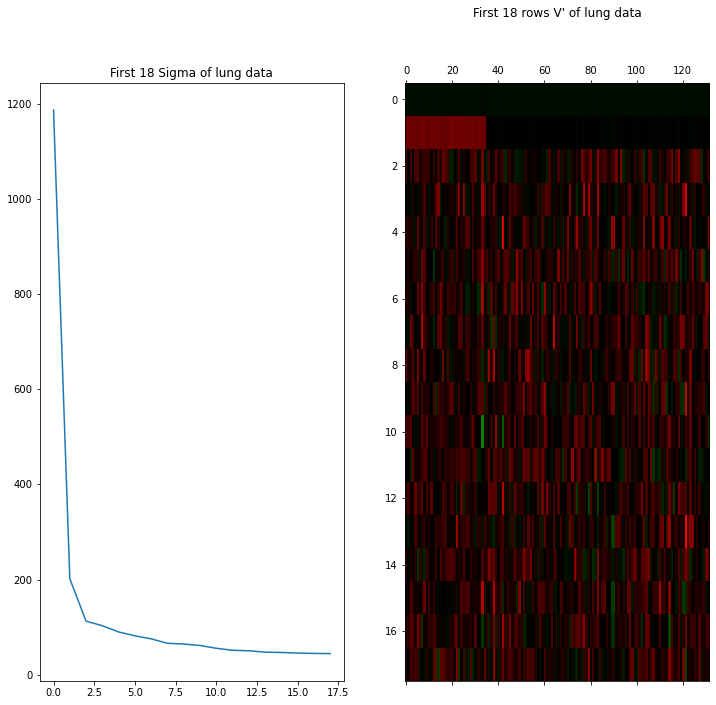

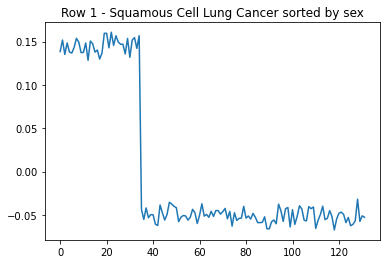

In [194]:
# Looking at the first 18

ULs = UL[:,0:18]
SLs = SL[0:18]
VtLs = VtL[0:18,:]

# visualize the output of the SVD
plt.matshow(ULs,cmap = cmap1, aspect = 'auto')
plt.title("First 18 cols U lung data")
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(SLs)
ax1.title.set_text("First 18 Sigma of lung data")
ax2.matshow(VtLs,cmap = cmap1, aspect = 'auto')
ax2.set_title("First 18 rows V' of lung data",y=1.1)
fig.set_size_inches(12,11)

fig, ax1 = plt.subplots(1)
plt.plot(VtL[1,:])
ax1.set_title("Row 1 - Squamous Cell Lung Cancer sorted by sex")

Text(0.5, 1.0, "Row 1 of V' with means: Female = 0.1449718357716035 \n and Male = -0.051021794280773816")

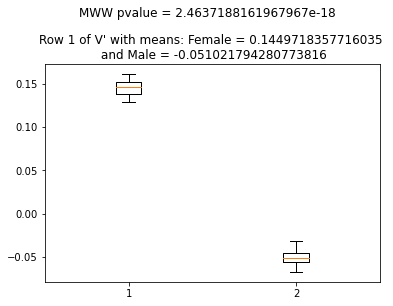

In [159]:
# look at column 2 w/pvalue and boxplot
Vf = VtLs[1,0:34]
Vm = VtLs[1,35:133]

meanF = np.mean(Vf)
meanM = np.mean(Vm)

u,pVlung = stat.mannwhitneyu(Vf,Vm)
fig, ax1 = plt.subplots(1)
ax1.boxplot([Vf,Vm])
fig.suptitle(f"MWW pvalue = {pVlung}",y = 1.08)
ax1.set_title(f"Row 1 of V' with means: Female = {meanF} \n and Male = {meanM}")

In [96]:
# sort so gorilla
ULgenes = np.concatenate((LungGenes,ULs),1);
# create a copy of the geneNames + U matrix so that sorting will not affect the original matrix
ULgenesC = ULgenes.copy()
# sort in both ascending and descending order by the 3rd index which is the 2nd column due to placement of gene names
ULgenesAsc= ULgenesC[ULgenesC[:,1].argsort()]
ULgenesDesc = ULgenesC[ULgenesC[:,1].argsort()[::-1]]

# print the genes so they can be copy and pasted into GOrilla - descending in this cell and ascending in the next
sortGenesAscL = ULgenesAsc[:,0]
sortGenesDescL = ULgenesDesc[:,0]

# print the sorted gene names for input into GOrilla
for x in range(0,LungGenes.shape[0]):
    print(sortGenesAscL[x])

EEF1A1
RPS3A
RPLP1
RPL39
PPIA
RPS23
RPS27
RPLP0
ACTG1
RPS4X
TMSB10
RPS15A
RPS24
RPL30
GAPDH
RPL18A
B2M
RPL12
TUBA1B
RPS7
RPL9
RPS15
RPL7A
RPL8
RPL21
UBB
RPS13
ANXA2
RPS17
TPT1
LDHA
RPL37
RPS16
NACA
RPL24
PTMA
RPS29
RPL3
RPL36A
PABPC1
RPL10A
RPS14
RPL35A
CD9
ACTB
RPS6
RPL4
RPS27A
RPL6
UBC
RPL5
RPL13
FTH1
RPL13A
FAU
RPS3
RPS2
ALDOA
GNB2L1
MYL6
RPL35
CALM2
RPL19
PRDX1
RPL18
CSTB
EIF4A2
MIF
NDUFB4
HMGN2
CHCHD2
RPL15
SLC25A5
S100A10
HLA-A
RPS20
RPL11
RPS8
SLC25A3
ATP5E
OAZ1
RPL29
CD63
HSPB1
COX6A1
HSP90AA1
PTGES3
CFL1
UBA52
RPS5
LGALS3
COX6C
RPS25
SNRPD2
SPP1
GPNMB
PSMA6
RPS9
C20orf24
EIF3E
RAC1
ATP5A1
NPC2
HSPC152
COL1A2
MORF4L2
COL3A1
ATP1B3
RHOA
HSPA8
EEF2
RPS10
EIF1
S100A6
CNBP
EIF4A1
NPM1
LAPTM4A
PPA1
GSTO1
CCDC72
DSTN
SNRPG
LDHB
HNRNPA1
TUBA1C
KRT19
MRPL3
RPL22
HIF1A
MORF4L1
CLTC
SRP9
SSR4
TOMM7
CYCS
FTL
COX5A
GLTSCR2
CCT4
HLA-B
SNX3
VIM
PFDN5
PHB2
S100A2
DYNLL1
HMGB1
HSPA5
ATP5H
C11orf10
TFRC
YWHAZ
YWHAQ
CSTA
PSMB4
NDUFS5
COX7A2
DSP
PERP
KRT6A
ATP5C1
BTF3
PCBP2
HLA-DRA
CDK2AP1
IGFBP7

MAML1
TWF1
DUSP12
TM2D1
UNC119B
RBM8A
PEX3
PYGL
ADAMDEC1
PTRF
MTMR2
KRT16
TMEM33
CDYL
TRIOBP
WDR45
UBE2J1
IRF1
MRPS2
PLSCR3
TMED1
EIF2B3
FLJ20323
DULLARD
LARS
CRK
MNT
TMEM11
FTSJ1
C10orf18
GDI1
PTHLH
CCDC109B
KIAA0020
NISCH
EXTL2
VPS8
UBE2D1
DDX41
TNIP1
MFSD5
LAMA5
PMS1
ZNF266
KATNA1
COL10A1
ETNK1
MTMR4
NSUN5
SUPV3L1
EXOD1
SLC25A1
THAP11
TFDP2
MSH2
ZNF12
RFC2
GULP1
BRD4
ASXL2
PTPRC
TAF15
HSPC111
TFAM
MPZL1
PREPL
FTSJ2
FLJ10292
DFFA
SLC39A1
LRRC42
ZC3HAV1
PLEKHA5
MIS12
DNAJB14
FAM20B
BCL2A1
GCA
LRRC41
FNBP4
TAPBP
TSPYL4
TFDP1
ACTR1B
EVI2A
IL7R
ILK
F13A1
PITPNC1
RGS5
IGFBP4
PSEN1
SMARCA5
SLC31A1
PHF21A
ZNF32
SETD1B
CPVL
C11orf49
PPP2R1A
TPST1
FZD7
TTC27
ANXA3
LAGE3
APIP
NUP62
ATF6
CDC37
OTUB1
SEC22B
REEP4
BTBD3
NOL8
ZBTB5
IMPAD1
FCGR2A
MAGEF1
COG2
TRIB2
WWP1
CSNK1G2
RNASEH1
IK
ALDH1A3
EDEM2
INSIG1
FCGR2B
CASP3
RPP38
COL11A1
ENTPD6
SERPINE1
CD2BP2
UPF3B
CPOX
SART3
HSD17B8
CLDN1
BPGM
MDFIC
RFC3
ACTR1A
CFH
PROS1
TRAPPC6A
RNF44
EIF2B4
TRIM2
SLC25A4
CPSF4
WSB1
NCKAP1
UBE2W
CBARA1
C9orf16
MTMR

CHEK1
METTL4
USP24
SGSH
TBL3
DGAT1
ANKRD5
SASH1
PID1
CSAD
PARG
SDCCAG8
PLAA
NKG7
SENP3
TFE3
CIC
SCMH1
GHR
JMJD6
PHLDA2
DEFB4
LZTR1
DGCR2
INPP5E
ZDHHC18
GOSR2
ARG2
ZNF143
GSDMDC1
TESK2
EHD1
SETD8
STAM2
DDX52
NCKAP1L
FANCE
SLC7A11
ALMS1
HDAC9
WNT2
CXorf9
SACS
SERPINB7
KHDRBS3
C1orf166
PCSK7
ZNF133
LSS
BDKRB2
PPFIBP2
SLC43A3
CD200
FKBP1B
QRSL1
MPP6
VNN2
KIF14
ZDHHC14
AP1G2
CDC42EP4
ABCF2
TRAF6
C1orf66
APBA2BP
ARHGEF2
PCTK1
RSAD2
TRIO
POU2F1
SALL2
AREG
CDKN2A
ZNF512B
FBXL15
MEX3D
PHF17
IL15
MAP3K8
FAM53B
POLR1B
TIMM22
SGK3
NRCAM
C19orf21
GPATCH2
TACSTD2
CD40
SCML1
KIAA0141
COPS7B
ZBTB24
THG1L
ARHGEF17
XRCC1
PGF
GAL3ST4
PAQR4
SLC17A5
PLEKHM2
OBFC2B
NR2C1
SFMBT1
SLCO4A1
C1orf112
HSF2
NTHL1
HS3ST2
CSF1R
TMEM62
TXNL4B
FABP4
BRPF1
WIPF1
C1QTNF3
REPS2
STARD5
APOD
KIAA0265
C1orf116
NHEJ1
APOL3
SMG7
ELP3
ZDHHC17
AP4M1
ATAD2B
DACT1
CHKA
RBPMS
SEZ6L2
GABRE
ZNF673
HS3ST3A1
ARFGAP1
SLC24A3
TEAD1
RPL10L
TLE3
TNFRSF14
SPAG9
PPM1H
SSX2IP
RHOBTB1
BCKDHB
MICAL2
PRKX
ARHGAP15
PTPRCAP
PTPN9
DPT
MTF1
ARS2
DOC

RENBP
PCDH1
BARX2
PDE6B
TJP3
TMEM59L
LOC55565
GPRC5D
RRAD
PMFBP1
HIST1H2BN
CYP1A2
HLA-DRB6
ARHGAP4
FBXO22
TNS4
TAOK2
APOC4
MPP2
NPR2
IVD
OGDHL
PKNOX2
SGEF
GPR64
ATXN2L
PFKFB2
JMJD5
CEP250
DAPK2
MEOX2
RAB30
ADRA2C
FGF6
ANKRD2
IQCC
INPP4A
SFRS15
RAB6A
SLC1A6
KCNG1
FAAH
LRRN2
RASGRF1
DUX4
PTPRD
MOCS1
FKBP8
RIMS3
PDE3B
CRCT1
DKK2
ZNF696
CDA
LOH3CR2A
ST8SIA4
EYA3
CREB5
CYP17A1
NNAT
INADL
GPR15
NT5M
DUSP9
MAPK8IP1
ITIH5
KHK
DKFZP564O0523
FAM107A
RPH3A
PLCE1
AATK
CD7
RCAN3
LMO6
APOA1
ZNF10
CDKN2D
TBX2
DGKQ
SFI1
ALOX12P2
THNSL1
MYO15B
AZGP1
CCRK
VN1R1
MAP4K2
CEACAM3
ST7L
C6orf134
GEMIN8
MBTPS2
CD1E
HIST1H2AG
TCHH
RICH2
FKSG2
NEUROD6
LOC51233
RAD52
EPHB1
CA5B
SCN4A
RALGPS1
DNAJC4
SMAD5OS
TNXB
TBKBP1
MADCAM1
PCDHGB5
LGI2
RAB27B
TRAIP
DBC1
FCHO1
COL9A2
DNM3
CDH22
ADD2
TAF4B
SCRN3
VAMP1
KCNN1
CHST4
C9orf61
SLC8A2
ELK4
PRR7
GAN
KIF5C
ABCD1
AMPH
DIRAS3
ANTXR1
SLC17A7
CASP5
CORO7
FANCA
SOX10
NXPH3
PLXNC1
FGB
ABL2
SPOCK3
C20orf112
SARM1
SH3GLB2
KIAA0427
ABHD8
POLM
HOXD10
SORBS2
KIRREL
TRAF3IP1
CRABP1


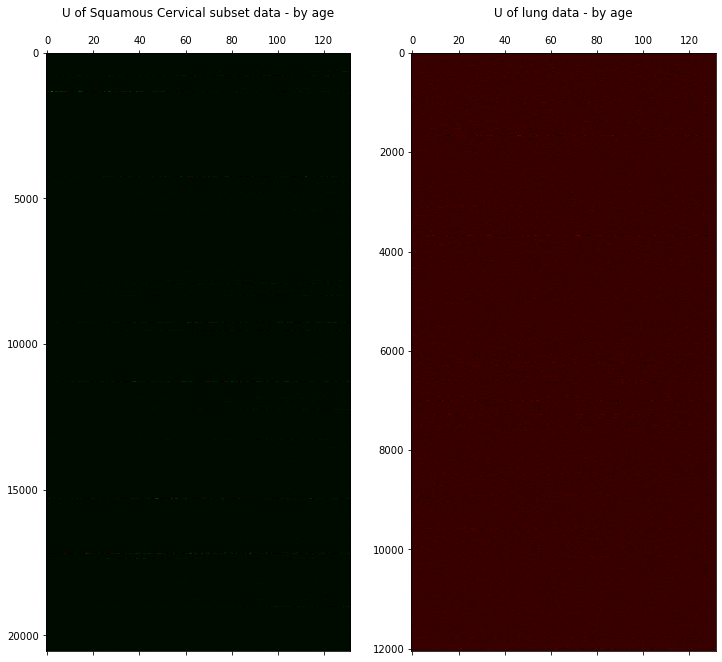

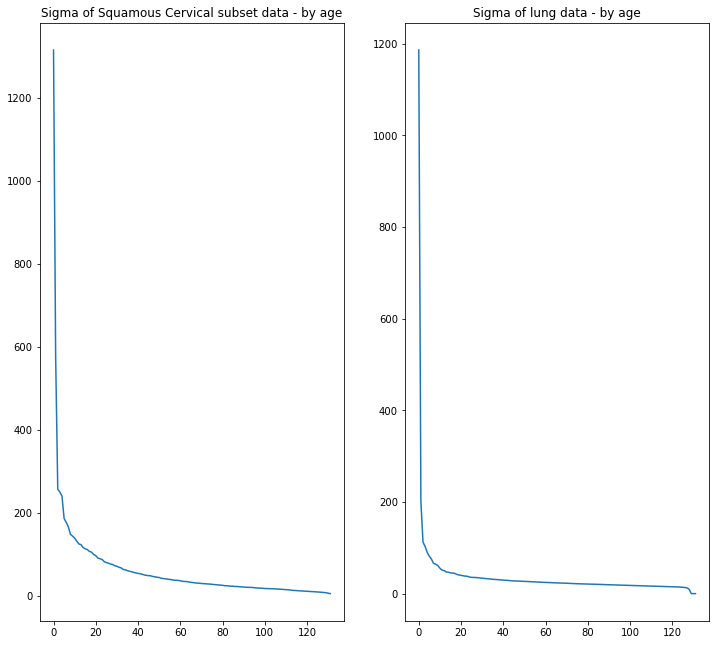

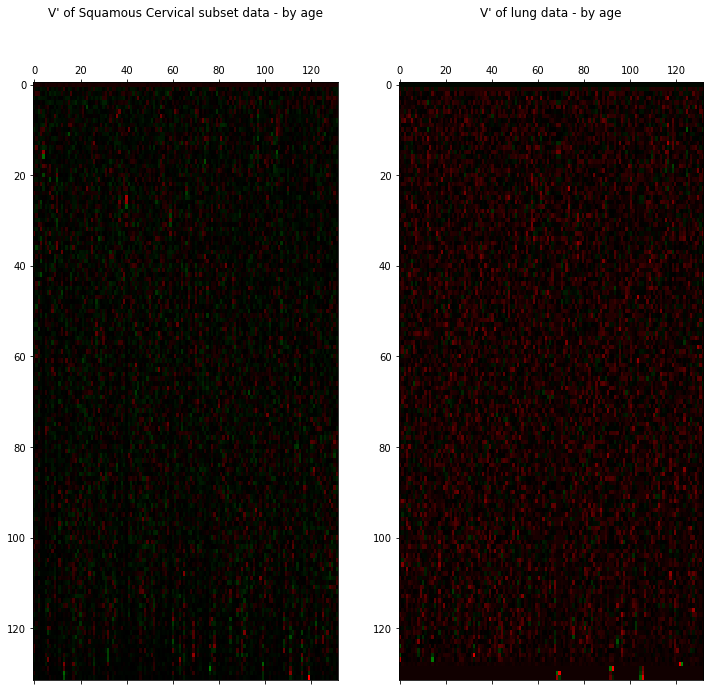

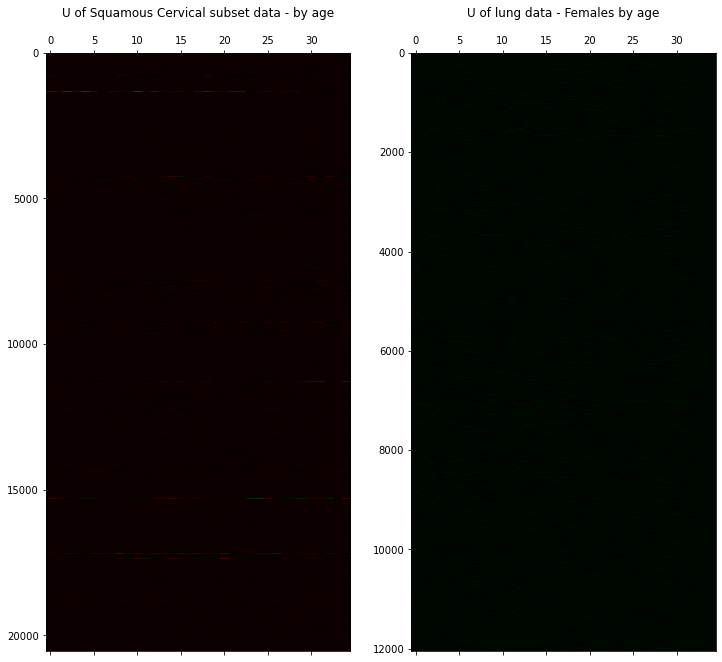

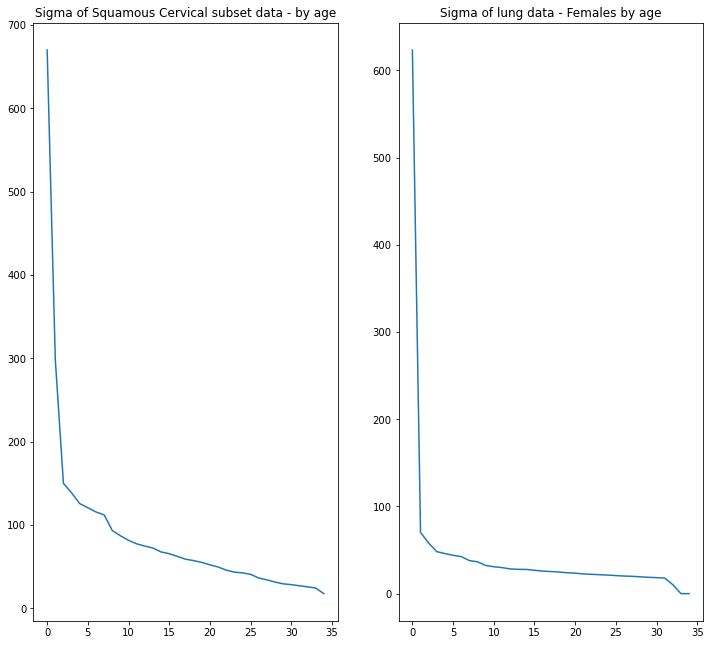

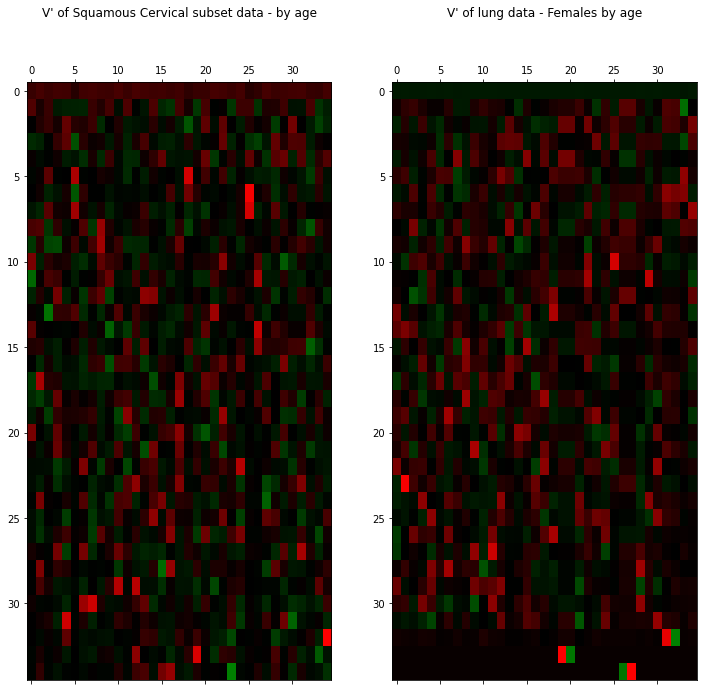

In [169]:
# performing SVD on SQ cervical and Lung side by side sorted by age
UsqSub, SsqSub, VsqSub = np.linalg.svd(SqLungSub,full_matrices = False)
UsqSubF, SsqSubF, VsqSubF = np.linalg.svd(SqLungFemaleSub,full_matrices = False)
ULa, SLa, VLa = np.linalg.svd(LungAge,full_matrices = False)
ULaF, SLaF, VLaF = np.linalg.svd(LungAgeFemale,full_matrices = False)
Usq,Ssq,Vsq = np.linalg.svd(SqAge,full_matrices = False)

# visualize the output of the SVD
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.matshow(UsqSub,cmap = cmap1, aspect = 'auto')
ax1.set_title("U of Squamous Cervical subset data - by age")
ax2.matshow(ULa,cmap = cmap1, aspect = 'auto')
ax2.set_title("U of lung data - by age")
fig.set_size_inches(12,11)

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(SsqSub)
ax1.title.set_text("Sigma of Squamous Cervical subset data - by age")
ax2.plot(SLa)
ax2.title.set_text("Sigma of lung data - by age")
fig.set_size_inches(12,11)

fig, (ax1,ax2) = plt.subplots(1,2)
ax1.matshow(VsqSub,cmap = cmap1, aspect = 'auto')
ax1.set_title("V' of Squamous Cervical subset data - by age",y=1.1)
ax2.matshow(VLa,cmap = cmap1, aspect = 'auto')
ax2.set_title("V' of lung data - by age",y=1.1)
fig.set_size_inches(12,11)



fig, (ax1,ax2) = plt.subplots(1,2)
ax1.matshow(UsqSubF,cmap = cmap1, aspect = 'auto')
ax1.set_title("U of Squamous Cervical subset data - by age")
ax2.matshow(ULaF,cmap = cmap1, aspect = 'auto')
ax2.set_title("U of lung data - Females by age")
fig.set_size_inches(12,11)

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(SsqSubF)
ax1.title.set_text("Sigma of Squamous Cervical subset data - by age")
ax2.plot(SLaF)
ax2.title.set_text("Sigma of lung data - Females by age")
fig.set_size_inches(12,11)

fig, (ax1,ax2) = plt.subplots(1,2)
ax1.matshow(VsqSubF,cmap = cmap1, aspect = 'auto')
ax1.set_title("V' of Squamous Cervical subset data - by age",y=1.1)
ax2.matshow(VLaF,cmap = cmap1, aspect = 'auto')
ax2.set_title("V' of lung data - Females by age",y=1.1)
fig.set_size_inches(12,11)


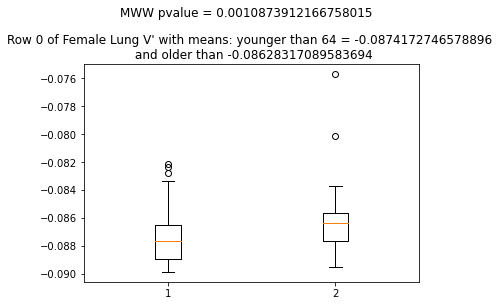

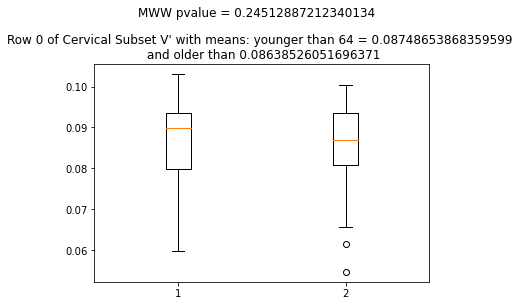

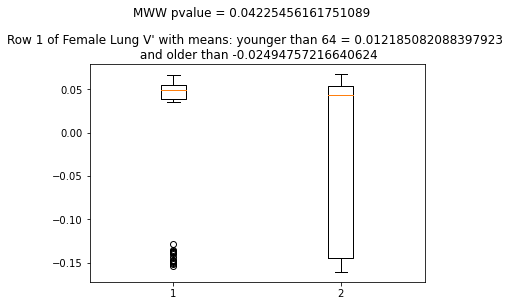

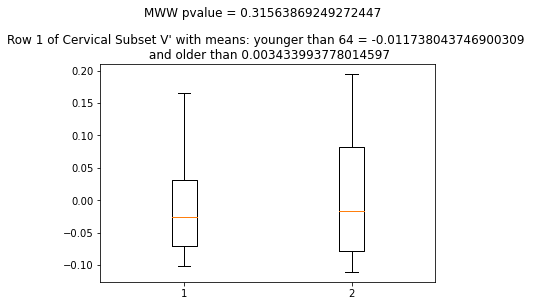

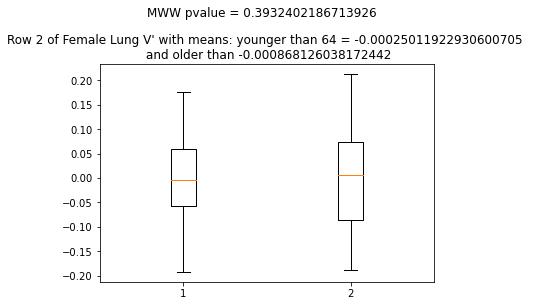

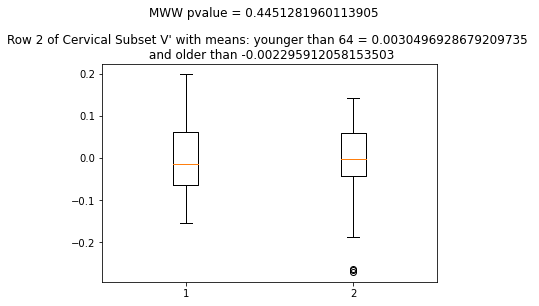

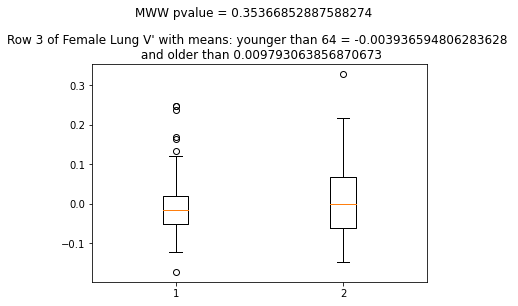

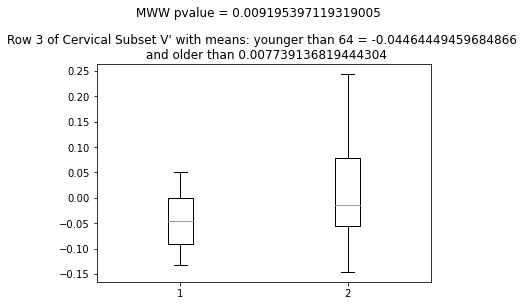

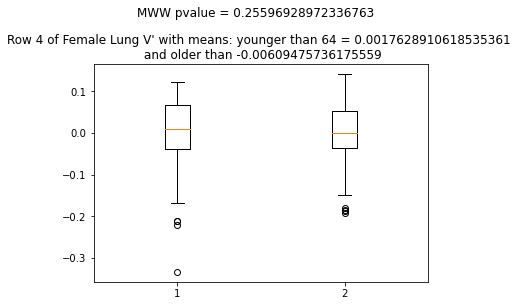

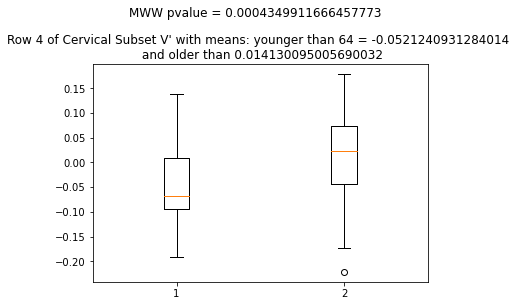

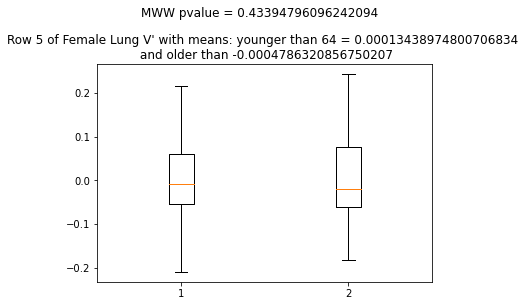

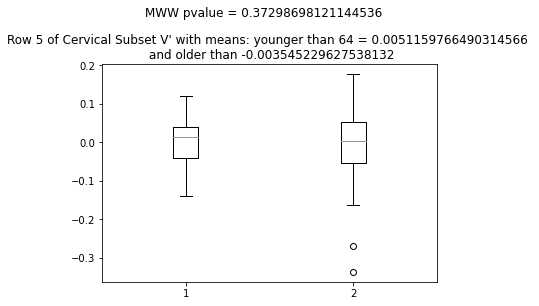

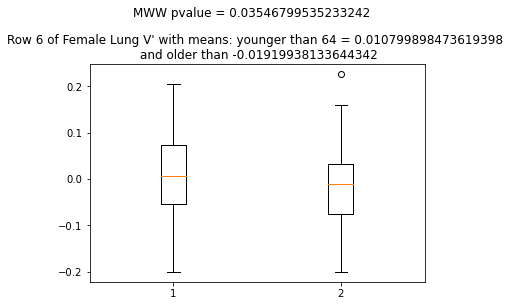

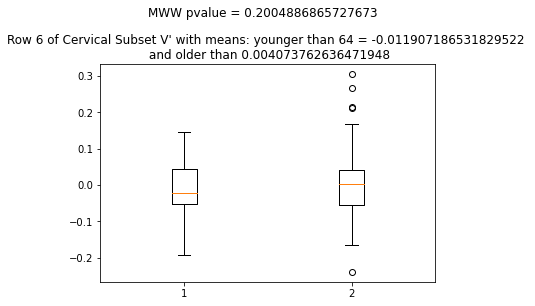

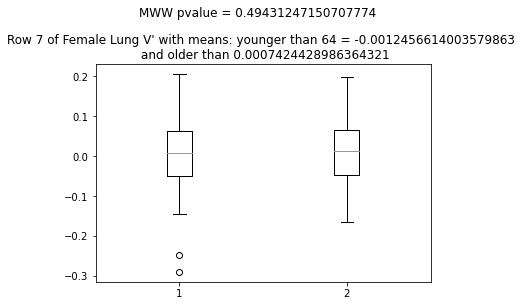

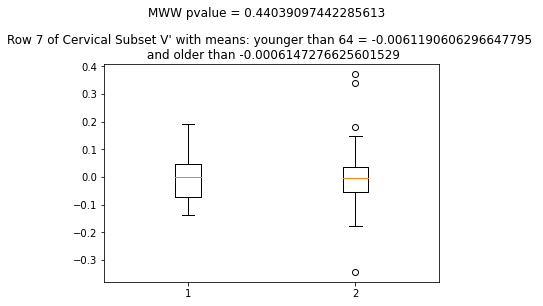

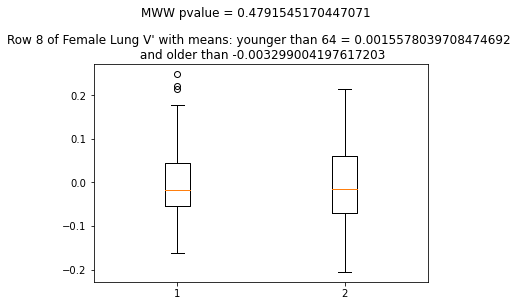

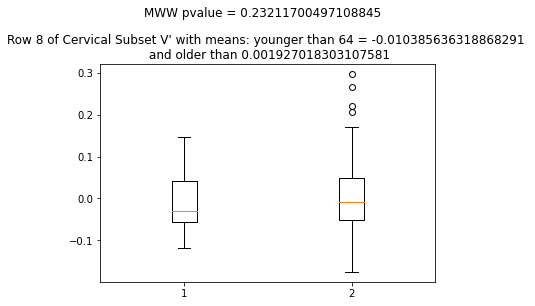

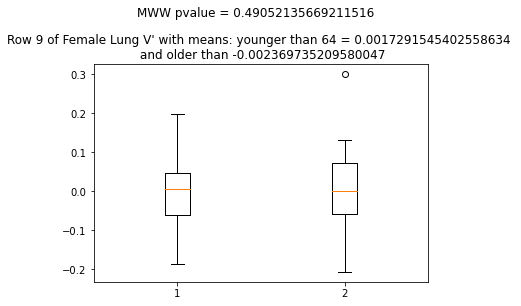

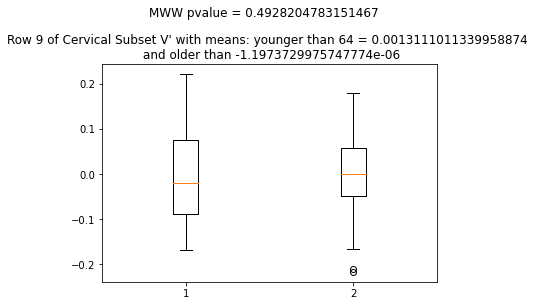

In [178]:
# Make boxplots for cutoff at midpoint 17
for x in range(10):
    cutoffL = 18;
    cutoffS = 8;
    VLaFold = VLaF[x,cutoffL:]
    VsqSubFold = VsqSubF[x,cutoffS:]
    VLaFyoung = VLaF[x,0:cutoffL]
    VsqSubFyoung = VsqSubF[x,0:cutoffS]
    meanFold = np.mean(VLaFold)
    meanFyoung = np.mean(VLaFyoung)
    meanSqold = np.mean(VsqSubFold)
    meanSqyoung = np.mean(VsqSubFyoung)
    
    u,pVlung = stat.mannwhitneyu(VLaFold,VLaFyoung)
    u,pVsq = stat.mannwhitneyu(VsqSubFold,VsqSubFyoung)
    fig, (ax1) = plt.subplots(1)
    ax1.boxplot([VLaFyoung,VLaFold])
    fig.suptitle(f"MWW pvalue = {pVlung}",y = 1.08)
    ax1.set_title(f"Row {x} of Female Lung V' with means: younger than 64 = {meanFyoung} \n and older than {meanFold}")
    
    fig, (ax1) = plt.subplots(1)
    ax1.boxplot([VsqSubFyoung,VsqSubFold])
    fig.suptitle(f"MWW pvalue = {pVsq}",y = 1.08)
    ax1.set_title(f"Row {x} of Cervical Subset V' with means: younger than 64 = {meanSqyoung} \n and older than {meanSqold}")

In [179]:
# Sorting U for row 2 yay - lung F age

ULgenesF = np.concatenate((LungGenes,ULaF),1);
# create a copy of the geneNames + U matrix so that sorting will not affect the original matrix
ULgenesCF = ULgenesF.copy()
# sort in both ascending and descending order by the 3rd index which is the 2nd column due to placement of gene names
ULgenesAscF= ULgenesCF[ULgenesCF[:,1].argsort()]
ULgenesDescF = ULgenesCF[ULgenesCF[:,1].argsort()[::-1]]

# print the genes so they can be copy and pasted into GOrilla - descending in this cell and ascending in the next
sortGenesAscLF = ULgenesAscF[:,0]
sortGenesDescLF = ULgenesDescF[:,0]

# print the sorted gene names for input into GOrilla
for x in range(0,LungGenes.shape[0]):
    print(sortGenesAscLF[x])

EEF1A1
RPS3A
RPLP1
RPL39
PPIA
RPS23
RPS27
RPLP0
ACTG1
RPS4X
TMSB10
RPS15A
RPS24
RPL30
GAPDH
RPL18A
B2M
RPL12
TUBA1B
RPS7
RPL9
RPS15
RPL7A
RPL8
RPL21
UBB
RPS13
ANXA2
RPS17
TPT1
LDHA
RPL37
RPS16
NACA
RPL24
PTMA
RPS29
RPL3
RPL36A
PABPC1
RPL10A
RPS14
RPL35A
CD9
ACTB
RPS6
RPL4
RPS27A
RPL6
UBC
RPL5
RPL13
FTH1
RPL13A
FAU
RPS3
RPS2
ALDOA
GNB2L1
MYL6
RPL35
CALM2
RPL19
PRDX1
RPL18
CSTB
EIF4A2
MIF
NDUFB4
HMGN2
CHCHD2
RPL15
SLC25A5
S100A10
HLA-A
RPS20
RPL11
RPS8
SLC25A3
ATP5E
OAZ1
RPL29
CD63
HSPB1
COX6A1
HSP90AA1
PTGES3
CFL1
UBA52
RPS5
LGALS3
COX6C
RPS25
SNRPD2
SPP1
GPNMB
PSMA6
RPS9
C20orf24
EIF3E
RAC1
ATP5A1
NPC2
HSPC152
COL1A2
MORF4L2
COL3A1
ATP1B3
RHOA
HSPA8
EEF2
RPS10
EIF1
S100A6
CNBP
EIF4A1
NPM1
LAPTM4A
PPA1
GSTO1
CCDC72
DSTN
SNRPG
LDHB
HNRNPA1
TUBA1C
KRT19
MRPL3
RPL22
HIF1A
MORF4L1
CLTC
SRP9
SSR4
TOMM7
CYCS
FTL
COX5A
GLTSCR2
CCT4
HLA-B
SNX3
VIM
PFDN5
PHB2
S100A2
DYNLL1
HMGB1
HSPA5
ATP5H
C11orf10
TFRC
YWHAZ
YWHAQ
CSTA
PSMB4
NDUFS5
COX7A2
DSP
PERP
KRT6A
ATP5C1
BTF3
PCBP2
HLA-DRA
CDK2AP1
IGFBP7

INPP5A
RPP40
PIGG
CTSO
AGA
PIGK
KIDINS220
GOLGA8A
MAD2L1BP
ASCC3
CSNK1D
DPY19L4
RWDD2B
SLC25A11
TOPORS
NECAP1
MORC4
NDUFS7
FOXK2
MFN1
TANK
HUWE1
TBCC
CHN1
ORC4L
METT11D1
FANCI
VPS37C
ANKRD11
P2RY5
MEPCE
GAPVD1
CDH11
CCDC92
SF3A3
MKNK1
MAP3K7IP2
CLU
BECN1
TBK1
SETD3
SCRN1
CPD
AKAP11
TRIM13
SCNN1A
CUL4A
IFIT1
SAP18
PRRC1
OXCT1
RAB2A
PRMT3
HGSNAT
INTS12
ZNF91
CTSD
EHBP1
CUL2
ERO1L
GEMIN6
IDH3A
TP53BP2
CDS2
IGLV2-14
GUCY1A3
TSC22D3
TBCE
ZNF274
KIAA0196
KLF6
AVPI1
ABHD11
ST14
B4GALT4
GIPC1
BIRC5
AMOTL2
PIP5K3
TSPAN31
PRPF6
BAZ1B
C1orf181
FILIP1L
CCDC91
KDELR3
C3orf37
CTNNAL1
ACN9
SEC24A
FKBP4
MRPS34
NIP7
FUS
RDH11
GNAI1
C19orf60
PTPN1
EBP
DUS1L
LGALS8
ALG6
ABCB7
HMGCR
COX11
GPD1L
OBFC1
ISOC1
ARPC4
C3orf63
C17orf42
UTP14C
TACC2
HIST3H2A
RAP2C
TMEM159
NINJ1
ATP9A
PFDN6
PARP6
DTL
CREB3
MTMR6
YLPM1
MAML1
TWF1
DUSP12
TM2D1
UNC119B
RBM8A
PEX3
PYGL
ADAMDEC1
PTRF
MTMR2
KRT16
TMEM33
CDYL
TRIOBP
WDR45
UBE2J1
IRF1
MRPS2
PLSCR3
TMED1
EIF2B3
FLJ20323
DULLARD
LARS
CRK
MNT
TMEM11
FTSJ1
C10orf18
GDI1
PTHLH

FAM49A
KIAA1026
SETD6
FBXL7
SKP2
PMS2CL
IFT122
PHC1
C10orf97
LARS2
MERTK
C14orf132
GRWD1
NAT9
CFB
STC2
WIF1
ZNF16
CCNK
UBE2D4
DHX57
MED15
THBS1
C16orf24
RRBP1
PHKA2
ZNF318
C20orf27
PRKCD
MN1
ZDHHC24
CXorf45
VPS13B
TRMT1
SS18
INHBA
WDR91
MAPKAPK5
CHEK1
METTL4
USP24
SGSH
TBL3
DGAT1
ANKRD5
SASH1
PID1
CSAD
PARG
SDCCAG8
PLAA
NKG7
SENP3
TFE3
CIC
SCMH1
GHR
JMJD6
PHLDA2
DEFB4
LZTR1
DGCR2
INPP5E
ZDHHC18
GOSR2
ARG2
ZNF143
GSDMDC1
TESK2
EHD1
SETD8
STAM2
DDX52
NCKAP1L
FANCE
SLC7A11
ALMS1
HDAC9
WNT2
CXorf9
SACS
SERPINB7
KHDRBS3
C1orf166
PCSK7
ZNF133
LSS
BDKRB2
PPFIBP2
SLC43A3
CD200
FKBP1B
QRSL1
MPP6
VNN2
KIF14
ZDHHC14
AP1G2
CDC42EP4
ABCF2
TRAF6
C1orf66
APBA2BP
ARHGEF2
PCTK1
RSAD2
TRIO
POU2F1
SALL2
AREG
CDKN2A
ZNF512B
FBXL15
MEX3D
PHF17
IL15
MAP3K8
FAM53B
POLR1B
TIMM22
SGK3
NRCAM
C19orf21
GPATCH2
TACSTD2
CD40
SCML1
KIAA0141
COPS7B
ZBTB24
THG1L
ARHGEF17
XRCC1
PGF
GAL3ST4
PAQR4
SLC17A5
PLEKHM2
OBFC2B
NR2C1
SFMBT1
SLCO4A1
C1orf112
HSF2
NTHL1
HS3ST2
CSF1R
TMEM62
TXNL4B
FABP4
BRPF1
WIPF1
C1QTNF3
REPS2
ST

CYP1A2
HLA-DRB6
ARHGAP4
FBXO22
TNS4
TAOK2
APOC4
MPP2
NPR2
IVD
OGDHL
PKNOX2
SGEF
GPR64
ATXN2L
PFKFB2
JMJD5
CEP250
DAPK2
MEOX2
RAB30
ADRA2C
FGF6
ANKRD2
IQCC
INPP4A
SFRS15
RAB6A
SLC1A6
KCNG1
FAAH
LRRN2
RASGRF1
DUX4
PTPRD
MOCS1
FKBP8
RIMS3
PDE3B
CRCT1
DKK2
ZNF696
CDA
LOH3CR2A
ST8SIA4
EYA3
CREB5
CYP17A1
NNAT
INADL
GPR15
NT5M
DUSP9
MAPK8IP1
ITIH5
KHK
DKFZP564O0523
FAM107A
RPH3A
PLCE1
AATK
CD7
RCAN3
LMO6
APOA1
ZNF10
CDKN2D
TBX2
DGKQ
SFI1
ALOX12P2
THNSL1
MYO15B
AZGP1
CCRK
VN1R1
MAP4K2
CEACAM3
ST7L
C6orf134
GEMIN8
MBTPS2
CD1E
HIST1H2AG
TCHH
RICH2
FKSG2
NEUROD6
LOC51233
RAD52
EPHB1
CA5B
SCN4A
RALGPS1
DNAJC4
SMAD5OS
TNXB
TBKBP1
MADCAM1
PCDHGB5
LGI2
RAB27B
TRAIP
DBC1
FCHO1
COL9A2
DNM3
CDH22
ADD2
TAF4B
SCRN3
VAMP1
KCNN1
CHST4
C9orf61
SLC8A2
ELK4
PRR7
GAN
KIF5C
ABCD1
AMPH
DIRAS3
ANTXR1
SLC17A7
CASP5
CORO7
FANCA
SOX10
NXPH3
PLXNC1
FGB
ABL2
SPOCK3
C20orf112
SARM1
SH3GLB2
KIAA0427
ABHD8
POLM
HOXD10
SORBS2
KIRREL
TRAF3IP1
CRABP1
DUSP8
GNA13
GPR172B
DLK1
VAX2
MYH14
BDKRB1
C20orf12
RHBG
KIAA0984
SLC24A2
P

In [177]:
# Sorting U for row 2 yay - sq sub age 
ULgenesFsq = np.concatenate((geneName,UsqSubF),1);
# create a copy of the geneNames + U matrix so that sorting will not affect the original matrix
ULgenesCFsq = ULgenesFsq.copy()
# sort in both ascending and descending order by the 3rd index which is the 2nd column due to placement of gene names
ULgenesAscFsq= ULgenesCFsq[ULgenesCFsq[:,1].argsort()]
ULgenesDescFsq = ULgenesCFsq[ULgenesCFsq[:,1].argsort()[::-1]]

# print the genes so they can be copy and pasted into GOrilla - descending in this cell and ascending in the next
sortGenesAscLFsq = ULgenesAscFsq[:,0]
sortGenesDescLFsq = ULgenesDescFsq[:,0]

# print the sorted gene names for input into GOrilla
for x in range(0,geneName.shape[0]):
    print(sortGenesDescLFsq[x])

S100A8
S100A9
RPLP1
TMSB10
B2M
GAPDH
HSPB1
KRT5
TMSL3
KRT17
ACTB
RPS18
KRT14
S100A11
TPT1
RPL37A
RPS29
RPL41
RPS11
RPS17
FTL
RPL35
RPS21
RPL8
RPS6
RPL35A
RPL31
IFI27
CD74
RPL11
RPS16
ACTG1
HLA-B
RPL30
RPS24
RPL36
KRT13
RPS4X
RPS8
KRT6A
RPLP2
RPS15A
RPS12
S100A6
MYL6
RPL19
RPL18
RPS14
RPS19
GSTP1
RPL27
SFN
ENO1
RPS3
S100A2
MT2A
KRT19
RPL38
CSTB
RPL24
KRT16
RPS9
RPL23
PI3
ALDOA
RPS20
RPL26
RPL7A
PTMA
PKM2
HLA-A
EEF1A1
RPLP0
FTH1
PFN1
IFITM3
TXN
RPL3
MIF
HLA-C
RPS27A
RPL13
RPS5
GNB2L1
ATP5E
LY6D
RPL12
RPL4
TAGLN2
RPS25
FAU
SLPI
TUBA1B
RPL5
RPS13
UBC
ANXA2
RPS15
RPL13A
RPL10A
CFL1
RPL29
RPS2
GNAS
COX7C
RPS10
KRT15
SPRR1B
NME2
NACA
UBB
CALR
RPL28
LGALS1
OAZ1
NDRG1
?
HLA-DRA
MYL12B
RPS7
ATP5I
KRT8
RPL37
COX6B1
TPI1
ANXA1
PPIB
MT1X
PRDX1
CD9
COX4I1
TUBB
CD63
EEF1G
RPL17
EDF1
EEF2
CALML3
S100A16
S100A10
RPL6
HSP90AB1
BTF3
NDUFS5
DYNLL1
S100A14
P4HB
COX7B
COX6C
FABP5
HBB
KRT6B
H2AFZ
IFI6
LDHA
RPL14
WFDC2
SLC25A5
LGALS7
SPINT2
ISG15
IFITM1
COX8A
SHFM1
RPL36AL
ATP1A1
RPL10
UBL5
HSPA8
S100A7
SAT1


SLC16A1
PDCD2
SELT
MRPS28
MLEC
POLDIP3
C9orf89
TXLNA
CDT1
OGFR
NUB1
GART
RNF126
ZNF428
ZNF146
TPRG1L
RYK
CLINT1
THOP1
LLPH
MTP18
CKMT1A
ITPKC
C3orf26
EML2
USP10
NUDT8
NUDT14
IFIT3
ARFGAP1
ATAD3A
PMM1
RALA
P4HA1
PDXK
FAM195A
EPS8L1
SEL1L3
MEST
SLC43A3
POLD1
SLC38A10
CSNK1G2
MICALL1
LARP1
PHF10
DCAF6
SPNS1
ADSS
XPNPEP1
A4GALT
ARL4D
CBWD3
COMTD1
FAM108C1
TCF3
TMC6
PACS1
TBCD
MAPKAP1
EIF5B
MKKS
CDC16
KCTD1
TRMT1
DEF8
TRIM26
TRIM8
GPRC5A
LUC7L
ATG4D
SELENBP1
ABHD14B
SIX2
TCTEX1D2
CELF1
ANAPC16
C7orf28A
FZD6
TM9SF3
ARHGEF19
BRE
GABARAPL1
CCDC53
ELOVL5
DDX11
AGAP3
ADIPOR2
GPR108
TJP2
CDCA4
VPS26A
LSM14B
WRNIP1
ROGDI
TMEM43
NCK2
FUBP1
SERINC3
AKT2
PLXNB1
PPP2R2A
BRD9
RAB31
KPNA4
FBRS
PON2
CIAPIN1
PDXDC1
XAB2
C1orf106
ARID1A
NISCH
SRA1
HMOX1
CBWD2
PMEPA1
SPINK7
PAPSS1
LRRC47
SNRNP27
NSUN5
LTB
ABCC5
OPTN
ROD1
C9orf119
OGT
RACGAP1
PSAT1
GBAS
DNAJA3
MLF1IP
MAP1LC3B
CINP
SP100
WSB2
PPAN
MID1IP1
CHCHD3
MRPL15
ESRRA
LDB1
TSPAN6
TMEM87A
SERPINE1
EPHB4
CALCOCO2
SH3BGRL
PFKFB3
CYCS
HOOK2
LOC388796
AIMP2

C6orf89
CUEDC1
PHKB
PLEKHF1
ANKRD57
SLC4A1AP
PPP1R14C
GRLF1
TAF9B
C2orf54
NCS1
USP19
WDR41
TIPARP
PEX13
DOM3Z
C7orf36
TOM1L1
PLCH2
SLC25A44
LETM1
BUD13
OLFML3
CNPY4
USP20
CXADR
LLGL1
TTC17
TFEB
NDRG4
WDR53
KIAA0391
LARP4B
KDELC2
NEK7
TSPYL2
COMMD9
AHSA2
CASP6
WRAP53
LOC100130776
PLEKHG4
ZBTB4
MFSD11
OXSR1
NUP160
GORASP1
FLT3LG
UGT1A7
SNAPC2
IQCG
SEC23A
HSCB
NFX1
TNPO1
NFE2L3
OVOL1
SPRR2G
IMPAD1
CWC27
ARMC8
ARMC1
FTSJD2
TRNAU1AP
C11orf80
KLHDC4
POLD3
PCMTD1
MEX3D
LRDD
SIN3A
TSR1
CYP4X1
HDHD1A
RAD51AP1
KIAA0415
TTC7A
PSPH
BRCA1
ARHGEF12
XYLT2
DNAJC3
DTL
PHAX
CTR9
LOC728855
BPTF
BUB1B
ATP6V0E2
SNX11
POLR3D
NUS1
SAV1
AP4M1
C9orf6
LOC100271831
MPV17L2
TOM1L2
RTCD1
ATP5EP2
SMAP1
C14orf159
RAD54L
UTP14A
RBM12
HS1BP3
SLC39A13
PEX5
HIP1R
SLURP1
RCCD1
MYO10
CCDC25
FNTB
LOC493754
MUDENG
CYB561D2
C6orf226
SULT1A1
PARP4
FARP1
GPX7
MTHFD1L
ARNT
YTHDF3
VPS37C
RIPK1
BCAR3
DECR2
RBM4B
EPN3
BTBD3
CXCL12
CCL4L2
RBM15B
HSPC157
NOL10
INTS7
NECAP1
CLUAP1
SEPT11
DRAM1
CCBL2
STAT5A
ADAM17
SEC63
SMG6
FAM173A
A

ANKHD1-EIF4EBP3
LILRB4
ANKRD22
PEG10
RENBP
POC1B
C3orf31
TRAF1
NRGN
ANPEP
AARS2
IQSEC1
C3orf19
FGD3
RAB3GAP2
FAM84B
RREB1
FZD2
FOXO4
MTMR3
KIF16B
ZNF397
IMPA1
RNF207
ZNF193
FAM117A
GATSL3
TK2
LCMT2
MARK1
BTAF1
TREM1
ACAD10
SPRR2B
ATR
FBXO17
PIGN
USP24
QPCTL
ATP2C2
PLEKHB1
BDP1
C12orf4
CGRRF1
PDSS1
C15orf41
DGAT2
WAS
NEURL4
PLA2G6
ZNF652
THEM4
C10orf78
DHX35
DAPP1
THNSL2
CBLL1
RASSF3
OXNAD1
ALDH3B1
LANCL2
C6orf120
HAUS6
PODN
NFIA
CNKSR3
PCGF6
HSF4
ABCB10
AMICA1
ATG7
PPAT
C16orf87
ATP9B
KIAA1199
DMXL2
CCDC93
ABHD5
ZADH2
MNT
ABI3
C4orf42
CEP72
C19orf20
ACAD11
C5orf45
NUDT18
WDFY3
GANC
FAM46A
PPP2R3A
HEATR6
INPP5E
MIB1
TMPRSS2
GABPA
SLC27A1
TRIM2
APPBP2
DUOX2
CRY2
C8orf38
CDC25A
POT1
DEPDC6
MUTED
SIK3
HEATR3
CCDC69
NFYA
TDRD3
KIAA0562
NAV1
REG1A
RLIM
PER2
MTPAP
MYO5C
SETD6
ESCO2
ESCO1
SNX13
CCDC132
TUBGCP5
ARRDC4
SFT2D3
ZNF354A
INPP5D
C1orf53
POLR1B
SOSTDC1
DOCK7
DCLRE1B
LOC651250
SLC25A20
IFT74
FAM54A
ABCA2
MSRB3
RLF
DHRS12
C21orf91
ELMOD2
DGKQ
STARD4
NAT6
ZNF579
ADAM12
FAM188A
CGREF1
TRM

PAQR8
GEMIN8P4
KCNK7
ITPRIPL1
AMN
LMLN
CAMP
MORN3
LRRC56
C6orf176
ZNF445
HOXA6
RECK
NPTX1
ADPRH
LRP5L
RASD2
ZNF670
SPATA18
ORAI2
ERG
LIPG
GPR39
PLD6
CYP26B1
LOC100132247
NT5DC3
ENTPD7
C3orf62
SDK2
C19orf51
C6orf225
IQCA1
PAPD5
GNAZ
CXorf36
C21orf7
USP27X
HIST1H2AM
RND1
MPZL3
ANKRD56
TSPAN2
ZNF10
LOC645676
EIF2C3
SEMA6C
HCFC2
TNFSF11
FOXL1
PRSS53
WNT2
ATXN7L1
BTNL9
MYSM1
PRR22
SLC46A3
POLR3G
SAMD12
LCE3A
MTMR9
FAM73A
STON1
DET1
ABO
LQK1
RASGRP2
C1orf69
CSDAP1
HOXA3
MACROD2
LOC100129550
SYN2
REEP2
FAM70B
ZFP30
PDE6B
SPATA13
LOC84856
BEND5
PARP11
OXER1
PLEKHG4B
SAMD4A
ITIH4
C10orf72
ATP7A
RAI2
APOBEC3H
PCSK1N
EREG
SEMA6D
UBE2QL1
CCDC153
C2orf60
EXPH5
MDN1
CCNJ
ZNF304
CHST10
SENP8
ZNF776
DNALI1
KIAA0895
SNORA27
CDH26
SLC4A7
MDGA1
ZNF675
KIT
FAM78A
SLMO1
IGSF10
C18orf1
KRT86
TTLL7
NOS3
C5
SLC24A1
KIAA1009
ITPR2
FAM175A
HSPB7
EML1
PUS7L
TOX2
DUSP18
SLC25A45
TWIST2
NHS
ACADSB
CCL22
CDHR1
SNORA37
NPSR1
C2orf65
PPM1L
ISM1
MRVI1
KRT79
TYW1B
GPR44
ZNF571
ROM1
CHDH
C17orf103
ZNF25
NEURL3
RPGR
LOC4

CNIH3
FLG
SLC38A4
TNFSF14
ZNF396
PCDHGB7
C17orf99
RAB19
INTS4L1
ANKAR
STK31
HNF1A
HRNBP3
CHRNA9
WDR49
NAPSA
KIAA1875
SMN1
TLR9
C13orf16
SLC16A7
SFMBT2
C6orf127
CGB2
GHRL
CRYBB1
NLGN1
SEMA3D
CACNB2
FLJ42627
MYBPHL
OR7E91P
C20orf132
HMGCS2
PTH1R
GGN
PF4V1
OOEP
SLC6A16
VCX3A
KCNE1L
C5orf20
LCN10
SCAND3
MTMR8
TTYH1
PP14571
OXCT2
C6orf204
ZBTB37
SLC13A5
ACAN
CDH16
UNC93A
FEZF1
CA14
CELP
C10orf105
PCDHGB1
BCAN
SIGLEC5
TNN
PRCD
DRD4
GJB7
HSN2
NKAIN1
LOC144486
KCNIP4
FMN1
HESRG
EFHA2
SNX31
GCNT4
PLP1
C5orf58
FLJ42875
LOC728723
SSX2
C9orf163
APOA1
RFPL3S
C6orf122
TOP1P2
C1orf177
AGTR1
CEACAM16
IGDCC4
PCK1
TRIM49
GP1BA
FOXD4L1
NR5A1
FGF18
TRIM78P
SNORA13
C14orf19
SLFNL1
SRMS
PPP1R14D
ADAMTS16
GDF9
CPEB1
SLC10A5
TMEM90B
SLCO5A1
CABP7
PRKG2
ZMYND12
LRRC39
DNM1P35
PKNOX2
PDE4C
SBK2
SCARNA4
DNAJC5B
CD163L1
FBXO15
KRT77
OTUD7A
SNORA49
PTPRD
PPYR1
RGL4
C7orf51
MYLK2
WSCD2
NTN5
KIAA1024
FAM66C
RIMBP3
LDB3
ONECUT2
ZNF382
CYP2C9
HRH2
CCDC85A
EPHA7
TCL1A
TRIM15
SPDYC
CA4
HPD
CDH22
IGSF9B
C6orf164
ST8SIA2


B3GALT1
OC90
CDCP2
OR2C1
GOLGA8G
AMAC1L3
DMP1
AVPR1B
APCS
CD5L
GLYATL3
CT45A2
CTNNA2
TCEB3B
C6orf94
CLDN25
PZP
NCRNA00051
TBX10
CHRNB3
OR10H2
SPATA16
GRIA1
RTL1
LRRC3B
CLVS2
FRMPD4
HHATL
FAM170A
EPB42
DEFB109P1B
NPPB
PRSSL1
FBXL21
MEPE
C6orf222
SYT14L
POU3F3
WEE2
SEBOX
PRPS1L1
SPEM1
CDH10
LRRTM3
SPO11
GAL3ST3
SSX4
C3orf49
POM121L4P
TAS2R13
NXPH1
UGT2B4
OR1L8
C15orf60
RFX6
AWAT2
NCRNA00114
MS4A3
KRTAP5-5
PRAMEF5
FAM66E
ANKRD33
PLA2G12B
FAM5C
CNGA3
SCTR
C1orf49
KRTAP12-1
HTR1E
C9orf71
PAR1
C9orf135
MAGEB6
CSN2
DNAJC25-GNG10
UGT1A5
RP1
TFDP3
MRGPRD
LPPR3
AMHR2
NOTO
OR2L1P
EPHA5
FAM169B
PKD1L3
POM121L1P
IL1RAPL1
FER1L5
IGLL1
UROC1
MYPN
ADCYAP1R1
LOC285045
TBX20
YIPF7
LOC388946
NBPF4
LHFPL3
DAD1L
XKR4
KCNA4
OR5M11
OR2T33
MRGPRX1
HTR2C
RFX4
LOC100192379
HRH4
MYH13
TAS2R30
IQCF1
C9
MAGEE2
SLC10A1
MESTIT1
TBC1D29
FLJ34503
TEKT1
C3orf48
C7orf52
C11orf34
NCRNA00161
FAM55B
TAT
ACSM2A
HPYR1
CCR9
LOC284232
PRDM7
RDH8
FLJ39609
CASR
CHRM2
BTBD17
RAD21L1
KRTAP5-6
GSC2
DNAH12
DSCR8
HTR3B
CPLX4
CD300LD


In [152]:
# performing gsvd to compare pattern weights in cervical vs lung squamous cell cancer

# using QR decomposition
#     for gsvd returns c,s,x,u,v where c and s are singular values for matrix a and b respectively, x is v't, and u/v are u

# compute the QR decomposition
#     requires concatenation of the two matrices vertically so columns are conserved

QRsqL = np.concatenate((SqLungSub,LungAge),axis=0)
q,r = np.linalg.qr(QRsqL)
# q output of QR decomp is split into Qsq and Qlung of size matching original input
Qsq = q[:SqLungSub.shape[0]]
QLung = q[SqLungSub.shape[0]:]
print(np.shape(QLung),np.shape(LungAge))

# compute SVD of these Q matrices
Usq,Ssq,Vsq = np.linalg.svd(Qsq, full_matrices = False)
Ulung,Slung,Vlung = np.linalg.svd(QLung, full_matrices = False)

# calculating generalized fractions
fractionSq = (Ssq)**2
total_fractionSq = np.sum(fractionSq)
gFracSq = fractionSq/total_fractionSq

# visualize fractions
positions_listSq = np.arange(1,Ssq.shape[0]+1)
to_plotSq = np.vstack((positions_listSq,gFracSq)).T
sortSq = np.argsort(to_plotSq,axis = 0)
print(sortSq)

(12041, 132) (12041, 132)
[[  0 131]
 [  1 130]
 [  2 129]
 [  3 128]
 [  4 127]
 [  5 126]
 [  6 125]
 [  7 124]
 [  8 123]
 [  9 122]
 [ 10 121]
 [ 11 120]
 [ 12 119]
 [ 13 118]
 [ 14 117]
 [ 15 116]
 [ 16 115]
 [ 17 114]
 [ 18 113]
 [ 19 112]
 [ 20 111]
 [ 21 110]
 [ 22 109]
 [ 23 108]
 [ 24 107]
 [ 25 106]
 [ 26 105]
 [ 27 104]
 [ 28 103]
 [ 29 102]
 [ 30 101]
 [ 31 100]
 [ 32  99]
 [ 33  98]
 [ 34  97]
 [ 35  96]
 [ 36  95]
 [ 37  94]
 [ 38  93]
 [ 39  92]
 [ 40  91]
 [ 41  90]
 [ 42  89]
 [ 43  88]
 [ 44  87]
 [ 45  86]
 [ 46  85]
 [ 47  84]
 [ 48  83]
 [ 49  82]
 [ 50  81]
 [ 51  80]
 [ 52  79]
 [ 53  78]
 [ 54  77]
 [ 55  76]
 [ 56  75]
 [ 57  74]
 [ 58  73]
 [ 59  72]
 [ 60  71]
 [ 61  70]
 [ 62  69]
 [ 63  68]
 [ 64  67]
 [ 65  66]
 [ 66  65]
 [ 67  64]
 [ 68  63]
 [ 69  62]
 [ 70  61]
 [ 71  60]
 [ 72  59]
 [ 73  58]
 [ 74  57]
 [ 75  56]
 [ 76  55]
 [ 77  54]
 [ 78  53]
 [ 79  52]
 [ 80  51]
 [ 81  50]
 [ 82  49]
 [ 83  48]
 [ 84  47]
 [ 85  46]
 [ 86  45]
 [ 87  44]
 [ 88 

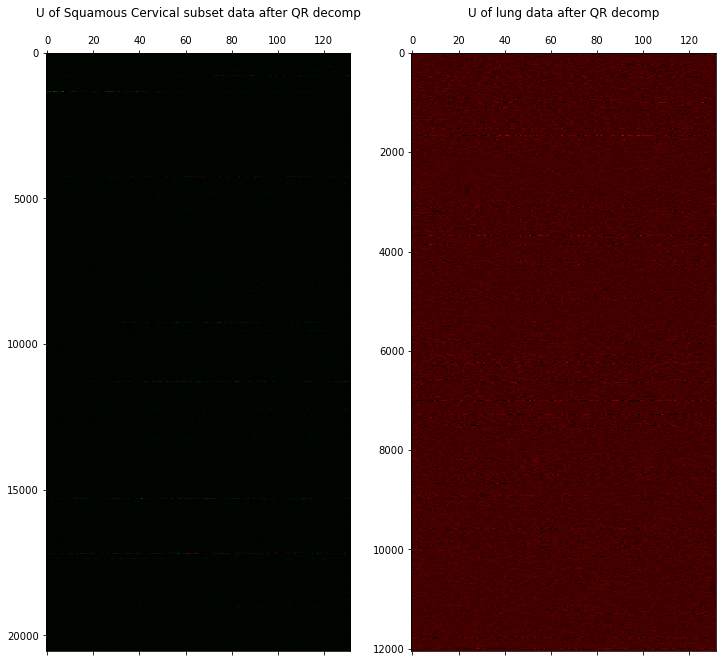

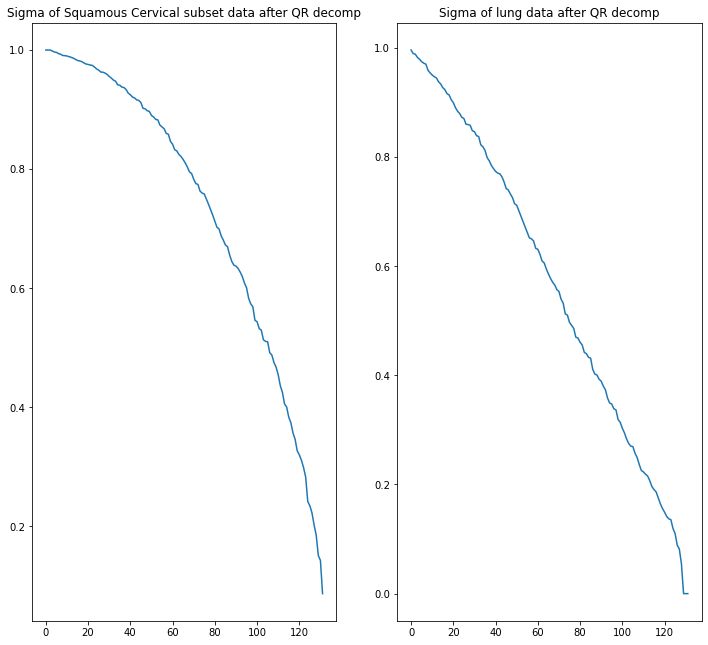

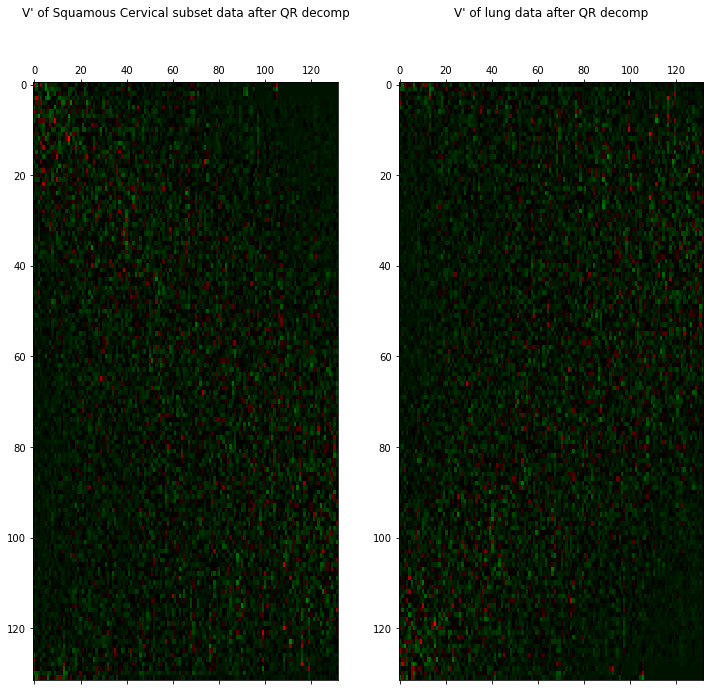

In [153]:
# visualize the output of the SVD
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.matshow(Usq,cmap = cmap1, aspect = 'auto')
ax1.set_title("U of Squamous Cervical subset data after QR decomp")
ax2.matshow(Ulung,cmap = cmap1, aspect = 'auto')
ax2.set_title("U of lung data after QR decomp")
fig.set_size_inches(12,11)

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(Ssq)
ax1.title.set_text("Sigma of Squamous Cervical subset data after QR decomp")
ax2.plot(Slung)
ax2.title.set_text("Sigma of lung data after QR decomp")
fig.set_size_inches(12,11)

fig, (ax1,ax2) = plt.subplots(1,2)
ax1.matshow(Vsq,cmap = cmap1, aspect = 'auto')
ax1.set_title("V' of Squamous Cervical subset data after QR decomp",y=1.1)
ax2.matshow(Vlung,cmap = cmap1, aspect = 'auto')
ax2.set_title("V' of lung data after QR decomp",y=1.1)
fig.set_size_inches(12,11)


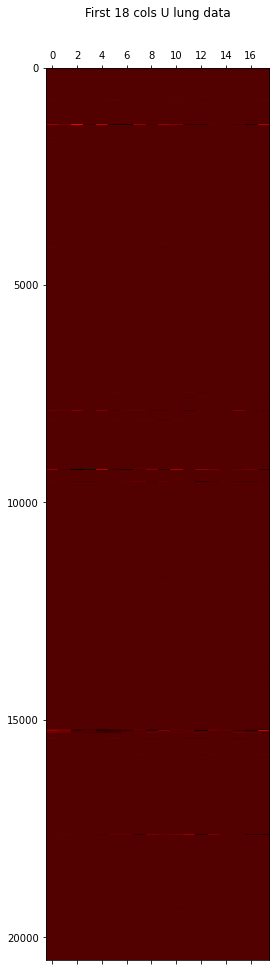

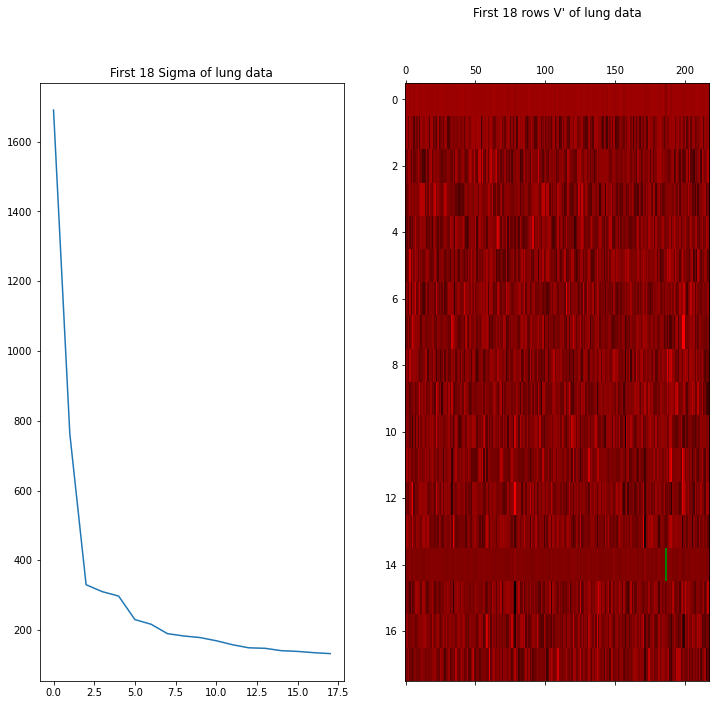

In [184]:
# quick look at prenancies 37 removed from 255 - 218 - least to greatest

SqPreg = pd.read_csv("/Users\Jordan\Documents\GitHub\PythonCode\Data Science for Engineers\BME6900 Cont\CervScaledSortNumPreg.csv")
SqPreg = pre.scale(SqPreg)

Up,Sp,Vp = np.linalg.svd(SqPreg,full_matrices = False)

# visualize the output of the SVD
plt.matshow(Up[:,0:18],cmap = cmap1, aspect = 'auto')
plt.title("First 18 cols U lung data")
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(Sp[0:18])
ax1.title.set_text("First 18 Sigma of lung data")
ax2.matshow(Vp[0:18,:],cmap = cmap1, aspect = 'auto')
ax2.set_title("First 18 rows V' of lung data",y=1.1)
fig.set_size_inches(12,11)

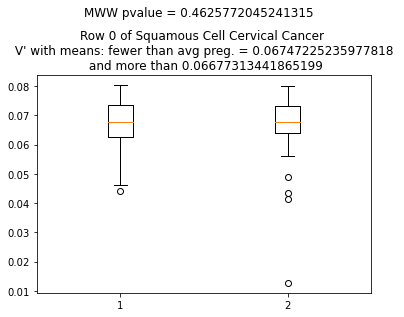

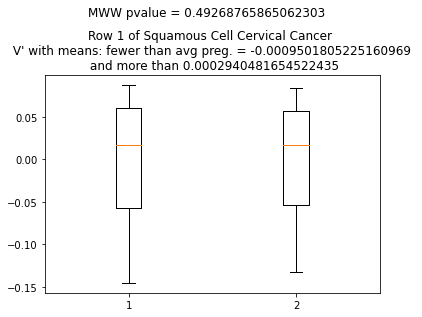

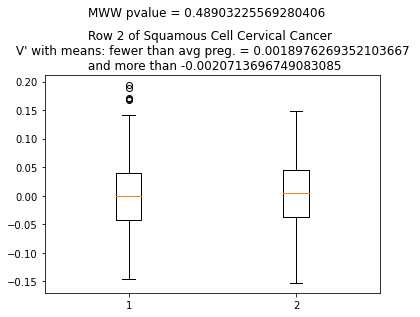

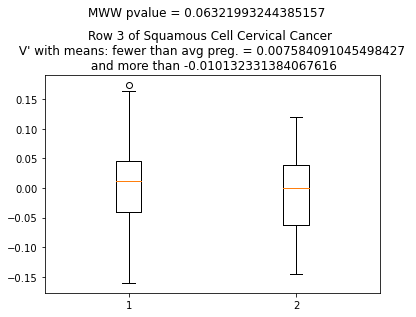

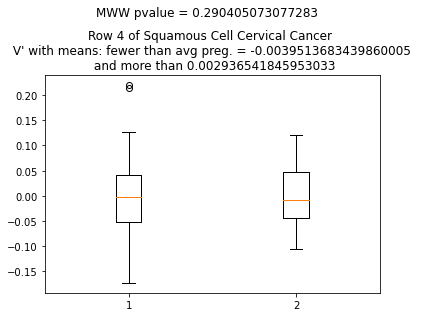

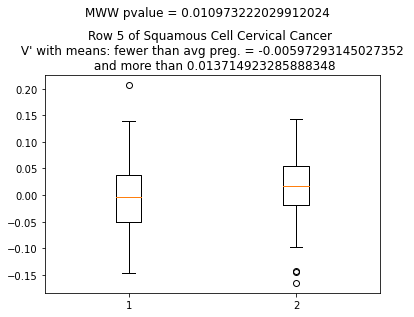

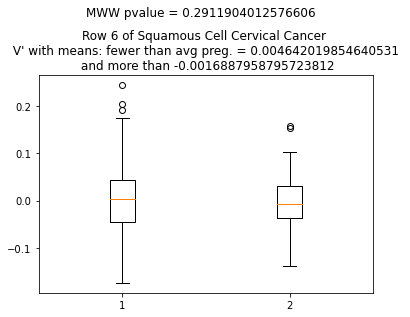

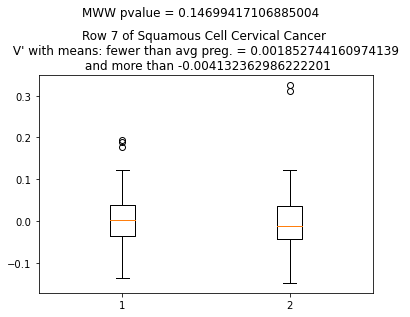

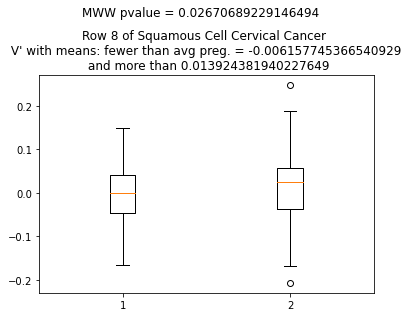

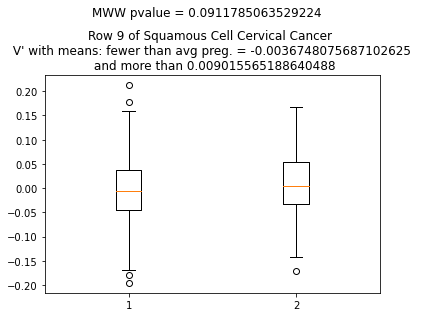

In [188]:
for x in range(10):
    cutoffL = 147; # at 4 preg - avg is 3.8
    VpL = Vp[x,:cutoffL] 
    VpG = Vp[x,cutoffL:]
    meanL = np.mean(VpL)
    meanG = np.mean(VpG)
    u,pVp = stat.mannwhitneyu(VpL,VpG)
    fig, (ax1) = plt.subplots(1)
    ax1.boxplot([VpL,VpG])
    fig.suptitle(f"MWW pvalue = {pVp}",y = 1.12)
    ax1.set_title(f"Row {x} of Squamous Cell Cervical Cancer \n V' with means: fewer than avg preg. = {meanL} \n and more than {meanG}")
    

In [189]:
# Sorting U for row 5 yay - sq preg
UpG = np.concatenate((geneName,UsqSubF),1);
# create a copy of the geneNames + U matrix so that sorting will not affect the original matrix
UpGc = UpG.copy()
# sort in both ascending and descending order by the 3rd index which is the 2nd column due to placement of gene names
UpgenesAsc= UpGc[UpGc[:,1].argsort()]
UpgenesDesc = UpGc[UpGc[:,1].argsort()[::-1]]

# print the genes so they can be copy and pasted into GOrilla - descending in this cell and ascending in the next
sortGenesAscP = UpgenesAsc[:,0]
sortGenesDescP = UpgenesDesc[:,0]

# print the sorted gene names for input into GOrilla
for x in range(0,geneName.shape[0]):
    print(sortGenesAscP[x])

?
?
?
?
OR9Q2
KRTAP10-1
AMELY
OTOL1
NXF5
RNASE11
KRTAP10-12
SNORD116-13
TBL1Y
SNORD116-14
KRTAP10-11
GLYCAM1
KRTAP10-10
TBC1D21
NPVF
LOC285370
TAS2R9
PAGE3
NPS
NPBWR2
SNORD116-15
BEYLA
GRXCR1
PAR4
OR9G9
SNORD116-12
OR9G4
SNORD116-10
OR8D4
OR8G2
OR8H1
SNORD115-48
SNORD115-4
OR8H3
TECTB
SNORD115-5
SNORD115-6
BSPH1
OR8I2
SNORD116-11
SNORD115-8
GPR148
OR8J3
OR8K1
OR8K3
SNORD115-9
KRTAP10-3
C6orf146
OR8U1
GPR6
RNASE12
C17orf105
OR8J1
NMS
LOC285692
LOC285627
C9orf27
SNORD116-26
RESP18
NCRNA00112
C14orf53
PDILT
SNORD116-27
HBII-52-24
HBII-52-27
HBII-52-28
C14orf177
SNORD116-25
LOC340094
HBII-52-46
SUN5
LOC728410
C14orf165
SNORD116-29
REG3A
LOC340357
SMR3B
KIF2B
RBMY3AP
SNAR-A13
HBII-52-45
TAS2R41
NCRNA00230B
TAAR2
OR8D2
LOC727924
C7orf66
C7orf72
SNORD116-16
SNORD116-18
BHLHE23
SNORD116-19
NLRP13
LOC286135
CETN1
CFHR5
C8orf71
BIRC8
LOC728276
SNORA42
SNORD116-22
NEUROD6
SNORD116-23
CFHR2
LCN9
TAAR9
TAAR8
SNORD116-24
SNORD116-1
OR8D1
GOLGA8F
SNAR-A2
SNORD115-11
OR5R1
SNORD12C
SNORD115-13
KRTAP19

WNT8B
C21orf90
AMELX
LOC285768
DHX40P1
C20orf144
COL29A1
SPINK9
GUCA1A
LRRC19
EXD1
LOC257358
GDF7
C20orf152
TMEM14E
PMCHL2
LOC100188947
ZACN
CLEC18C
OPRD1
SYCN
GALR3
LOC220429
GBA3
GKN1
DEFB104A
BET3L
BTNL8
ASB4
CYP4F2
SCGB3A2
UGT1A3
DEFB124
INSRR
STMN4
C3orf50
GABRA1
TDGF1
MYF6
ZPLD1
DCDC1
EFCAB5
C15orf28
CER1
DCAF12L2
SNORA75
BPI
CALY
DSCAM
GABARAPL3
MYL2
COX8C
SRD5A2
ATP2B2
ABCC8
ARX
NPY6R
FAM186A
SYT6
TPTE
C1orf173
LIPN
TECTA
C4orf39
WDR65
EFCAB3
LOC93432
C6
MYO18B
C10orf131
KLHL10
EYS
FAM138F
RNF186
FLJ40292
AGXT2L1
TUBA3E
PSG1
TRIML1
OR52N2
CTRB1
C1orf189
C3orf74
INSC
KCNH5
CCDC62
CRB1
APOH
C3orf43
TFAP2B
RELN
DIRC1
SH2D7
DEC1
PLAC4
CXorf50B
CHRNA4
IGSF22
TMPRSS9
MSX2P1
TRH
CRLF2
OR7C1
CPB2
HOXD12
RIMBP3C
GGT8P
CYP2A6
GLP2R
PCDHGC4
LRP1B
PFN3
LIM2
CFHR1
CRYBA4
SLC12A5
LOC347376
TCL6
PADI6
ZNF804A
GMCL1L
TRIM61
NOL4
LOC55908
LPAR4
OR1F1
RPL23AP32
GPR182
HIPK4
FAM9B
C9orf128
TMEM90A
LCE5A
C22orf24
GRM7
SV2C
DCST1
CUBN
FAM196B
SLC5A2
LOC342346
LOC283761
NCR2
COL9A1
HIST1H1A
IL13
CPN

ZNF404
FREM2
HHIPL2
FOXD2
TLX2
PLGLB2
DPY19L2P2
TIMP4
CD40LG
ZNF132
FCRL6
C21orf84
ATP10A
SLC30A4
ZBTB32
ROPN1B
EFHC2
MYOM3
OPRL1
GUCA1B
LONRF3
STAC
AGTR2
ZNF469
CLDN22
ZNF699
C9orf110
EML6
FOXE3
LEKR1
TMEM170B
TEC
WDR78
LOC148189
SLC9A4
FOXD4
CASC2
SCARA5
RNASE10
CLK2P
UGT2B7
B4GALNT2
C11orf66
C1orf182
TH
C17orf57
ECEL1
PAK3
RGPD5
SNORA7B
FAM78B
ZFPM2
SNORA23
LINGO2
ZNF284
TXNDC2
ADRA2B
FLJ13197
SLC2A14
IPCEF1
ZNF625
CCDC11
TRPC4
C20orf165
OMD
ZNF570
SEC14L4
ADCY5
HDC
HIST1H4D
SSTR5
C14orf50
CRYGN
BMS1P4
C14orf34
KBTBD8
BTC
SLC16A6
ZNF214
KRTAP4-1
NKAIN4
REM2
LOC641298
CEND1
CXCR5
FHIT
C22orf45
ZNF709
ASAH2B
FCGR3B
TCEAL5
AVPR2
HS3ST4
P2RX1
FAM19A5
MTUS2
PNMT
CD80
MLXIPL
RAET1K
CRISPLD1
GPRIN3
IL13RA2
MGC16142
ZC4H2
TMEM156
TLL2
KBTBD11
PLAG1
FOXI1
P2RX7
SIRPB2
PDE1B
PARP15
ZNF429
TUBB8
ZNF322B
CHSY3
KIAA1211
SYN1
C8orf84
MGC16275
ZNF460
LAIR2
NCRNA00092
DCLK1
FAM162B
ORM2
PCDHB3
C12orf72
PAR-SN
KLRA1
OXGR1
GABRA5
C21orf34
PARD3B
HIF3A
EPHA3
CCDC102B
SMTNL2
LSAMP
C3orf42
PPARGC1B
TRPV

PMS2L3
ZNF529
HS3ST6
DMRTA2
TICAM2
VSTM2L
RBKS
HAND2
GPR98
SNORA24
THAP10
SCGB2A1
FAM132A
ZNF286A
GPR143
TMEM38A
TRIM23
HIPK2
PPP1R3G
SERPINF2
C12orf5
P2RY1
SIX4
ZSCAN18
CORO6
TMCO7
HRASLS
ZNF155
GK
TUBB4
FGF8
CHIT1
ZBTB8A
TRANK1
CYP2E1
WDR7
FAM49A
ZBP1
PTENP1
DHRS9
AP1S3
TMEM92
CARD11
HRH1
MST1P2
C20orf177
TIRAP
CSPG5
GJA4
C15orf62
EXOC6B
LYL1
CRLF1
TMEM120B
TUBBP5
SPON1
ZFP41
ACACB
CELF2
C19orf39
C21orf15
LOC400043
IL24
FBXO41
C19orf55
ALPP
MYO7A
SLC16A13
LSM11
SNX29
TRAF6
PGPEP1
MEG3
PAQR6
PTPLA
ZXDB
ZNF138
IL17RD
HCN3
LAMC3
TMEM88
FAM21A
DQX1
NPPC
PGM2L1
GGTA1
TTC33
INTS2
ABCA5
ST3GAL6
LOC643008
EIF4E3
CCDC138
SEPT7P2
ABLIM3
HHAT
P4HA3
RELL2
LOC374443
HFE
FBLN7
DHDH
SERTAD4
CCBP2
C3orf33
ALOX12B
CXorf23
LGR6
SLC17A9
GRIN2D
FAM178B
OTUD3
N4BP3
USP13
LIFR
GAB2
C6orf162
C4orf19
PYROXD2
RHOU
N6AMT1
TMEM192
SYT1
RFX2
INPP4B
USP45
CPPED1
TNFSF13B
CPAMD8
UBR1
PCDHB14
FKTN
SLC10A6
FRS3
RARB
AMT
HSPA7
CC2D2A
TMCC2
CTLA4
LOC147804
ZKSCAN4
CTU1
NUFIP1
LOC100132111
VCPIP1
XPO4
SIGLEC1
C13orf31

TGM3
AGL
ARVCF
NLE1
AXIN2
WNK2
TSPAN5
FBRSL1
TLE4
FBF1
CTTNBP2NL
FGD1
TTC8
CHUK
KIAA1524
CYGB
CCNT2
USP25
BACE1
ZNF322A
ABCA3
TOPORS
SENP1
CDAN1
RNF168
LMBR1
FBXO8
SNORD10
SSH1
CRADD
EVI5L
KLHL24
RRAGB
NHLRC3
DDX28
SNORA10
FAM63A
TJP3
SLC35F2
FAM50B
NCF4
NDST2
MYH10
SEPT5
FDX1
FANCC
FAM175B
C1orf27
TMC8
ZNF828
WBP4
ARTN
RNF2
SASH3
TBC1D3B
RASL11B
KRT75
EDEM3
C3orf57
PHLPP1
POMZP3
MAGED4B
ELMOD3
DPY19L4
OSBPL3
TTC9
PBRM1
PLEKHA7
TRAIP
CDK17
PHTF2
KIAA1033
SLC43A2
SPSB2
HOXB3
HOOK1
C1orf115
FLJ35220
GSTT2
NUDCD1
C6orf70
SLC6A6
AMACR
PLBD2
C3orf38
OSBPL8
LOC91316
TUBD1
VTCN1
ZNRF2
AMMECR1L
FZD8
MED13L
ARL3
COL14A1
MSI2
OBSCN
CDC25C
NUDT4
ZHX2
PLXNA3
ACOX3
UCA1
TGDS
SMARCAD1
MYO5B
GTF2H2C
DCAF16
AFAP1
KIAA1609
ACOT13
LIG3
PCTP
GGT5
KIAA0776
CCNYL1
PIK3CA
TMEM218
GNB1L
C20orf96
CHST15
WNT5A
IL34
NEDD4L
EAF2
DNMBP
RANBP10
ELL3
EIF2AK3
RNFT1
ZBTB44
DENND4C
CCDC106
LRRCC1
COL9A3
PTPN3
RHOBTB3
RNF219
ANKMY2
GORAB
FILIP1L
FGFRL1
C1orf109
C10orf4
ETAA1
PFKFB4
RTN4R
GALNT10
RAB22A
ZNF592
ABI2
KRIT

SLC44A4
EID2
U2AF1L4
DVL2
NEFH
ELL2
ATMIN
BIRC3
AFTPH
ZBTB17
EFNA3
RFC1
FAM26F
DCK
PLD2
SEPT6
THOC5
RRN3
DHRS13
CERK
CCDC43
CCDC55
PCBP4
DEFB4A
WDR76
LPAR2
MUS81
SIPA1L1
LRBA
SEC14L1
GINS3
HLA-DQB2
MORC4
CPOX
RAC3
FANCA
KLF13
RBM14
LOC151162
SNX15
GAMT
NT5C2
PRKCH
CHAF1B
TTC19
FNBP4
UBLCP1
PPP1R15B
PRKAA1
FAM127C
MST1R
CHD1L
LOC388152
RSU1
CHEK1
IGF2R
AGBL5
RPIA
POFUT1
TMEM18
ISCA1
HEXDC
SCRN1
UBAP2
SLC7A1
AMPD2
MAST2
UBA5
BEX4
CISD3
VARS2
RNF185
SMOX
NR1D1
BAZ2A
STK19
EPB41L2
DNM1
GRAMD4
COMMD8
MAPKAPK3
PCDH1
CHST14
GNPTAB
C2orf64
LRCH4
C19orf25
HEATR2
MXD4
ASL
CYTSB
VAPB
OPA1
CRK
CMTM3
DUS3L
AP3B1
CRYZ
GPD2
CABC1
C1orf66
KDM2B
IL15RA
SLC30A9
PIGP
NDUFS1
HIST1H2BJ
SUZ12
STRBP
MXRA5
PCGF3
ATAD1
ZNF330
UGDH
MAP7
AKAP13
PRRG4
FERMT1
DIMT1L
OGFOD1
CRCP
TRIB2
PRKRIP1
FAM104B
ACD
FAM98B
PPP2R3B
PGS1
GATM
FAM25A
PCYOX1
MAD1L1
PICK1
TRMT2A
MRPL35
NOMO3
STARD5
ZNF282
RHBDF1
DDX46
WDR43
RIOK1
RNASEH2C
RNF31
TMCO3
CCDC88B
HSD17B11
SDC3
C10orf10
NAT14
SERPINA1
KBTBD2
IFT122
ARSD
PPFIA1
ACAT1
CHUR

APOL2
SLC25A28
CLEC2B
TRAF4
CD320
CCDC47
SCYL1
MMP13
COMMD2
TSC2
CTSK
KIAA1967
FAM3A
EXOC7
NSFL1C
ICAM1
LOC728643
LAMB1
METAP1
FAM125A
RAP1A
BCAT2
SPTLC1
VPS35
BCL7B
ZDHHC5
MBTPS1
BECN1
PTP4A1
TBRG4
RNF213
WDR45
CYFIP1
TM9SF1
MMP7
CRELD2
HERPUD1
ADAM6
HIST2H4A
RELA
RGS10
SFRP2
LSM10
MMP10
C12orf10
BNIP3L
FAM89B
LMAN1
ALDH3A2
PMPCA
C5orf15
RPA1
ALKBH7
RIC8A
DBN1
PDHB
TMED4
SC4MOL
ABCF1
NSDHL
MAL
P4HA2
MAD2L1
TNFRSF21
CHID1
TUSC3
QTRT1
TPP1
MRPL49
DHRS7
MAP2K1
HMOX2
THRAP3
ZNF638
RBBP8
PNN
LIG1
AATF
RAE1
UBQLN1
HEBP1
PXN
ORMDL3
GYG1
PBXIP1
CCNL1
IGSF8
CACYBP
PRMT5
ISY1
C7orf11
MLLT6
GNL2
THYN1
OAZ2
SIRT3
DDB2
ICT1
GPR172A
C7orf40
PTGES
TIMP3
FAF1
ACLY
HIST1H2AC
COL4A1
SAR1A
ADPRHL2
UBTF
SSBP3
NME3
MEAF6
TADA3
MGC29506
NGDN
CAPZA2
MCRS1
YME1L1
C7orf44
PAK4
VPS16
SPHK1
IL4R
ESRP1
DAXX
JAK1
MUC20
COL7A1
NUP93
NOLC1
PTGFRN
USF1
CWC15
C8orf4
WAC
HEXA
C1orf85
UBAC2
PTHLH
GOT1
CD14
RING1
SLC44A1
CDKN3
SURF2
PPP5C
LLGL2
ANKRD10
CHCHD5
ALCAM
NCKAP1
MACF1
COPA
WIBG
ID2
ANP32E
MALAT1
AKT1S1
SDF2L1
